## A brief description of the problem

The proposed task is to evaluate the feasibility of using the ONS production data to predict the Eneva's quarterly prodcution report.

## The methodology used
The methodology consist in following steps:

    - acquiring the data from the websites OSN and Eneva. ( using urllib.request )
    
    - organize the data acquired from both sources to allow us to connect and compare the data.( using pandas dataframes )
    
    - compare the data from each powerplant, also compare the  sum of all powerplants
    
    - plot the the comparision.
    
    - plot the  correlation map.
    
    - create a model to predict the Eneva production report using the ONS value.
    
    - evaluate the results obtained via model (validation process).
    
    - write down the final observations and remarks based on the findings.


In [2]:
#PREAMBLE ALL THE USED TOOLS
import urllib.request
import csv
import codecs
import os
import pandas as pd
import glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
import warnings
warnings.simplefilter('ignore') 


## Functions

In [3]:
## FUNCTIONS

def ONS_files_get(file_name):
    #FUCNTION TO GET THE .csv from ONS website. There is only one input, which is the file name.
    # for 2021 and below the structure is "_YYYY" e.g. "_2016" the .csv file with all yearly data is downloaded
    # for 2022 and above the structure is"-2_YYYY_MM" e.g. "-2_2022_05" the .csv file with the monthly data is downloaded
    current_path = os.getcwd()
    url = 'https://ons-aws-prod-opendata.s3.amazonaws.com/dataset/geracao_usina_2_ho/GERACAO_USINA'+file_name +'.csv'
    file_path = current_path + '/GERACAO_USINA' + file_name + '.csv'
    urllib.request.urlretrieve(url, file_path)
    

####
## SINCE THE ENEVA DATA IS NOT PROPERLY STRUCTURED IT IS NECESSARY TO REORGANIZE THE INFORMATION ACQUIRED FROM THE .XLSX.
# AS  COLUMNS  THERE IS NO UNIQUE PRIMARY KEY ON THIS DATAFRAME, INSTEAD A COMBINATION OF "LOCAL" AND "QUARTER" IS THE 
# UNIQUE COMBINED KEY.
def ENEVA_DATAFRAME_CONTRUCTION(Local,POSITION,file_path_ENEVA):
    # This function reorganize the ENEVA operational data from the .xlsx
    # There are three inputs on this function:
    # local == the name of the "plant" e.g. "Porto do Itaqui"
    # Position ==  is the row in the data from respective plant starts on the .xlsx starts
    # file_path is the path where the .xlsx is saved
    # the resulting dataframe is composed by the following columns
    # Quarter ==  
    # Disponibilidade (%) ==
    # Despacho (%) ==
    # Geração Líquida (GWh) ==
    # Geração Bruta (GWh) ==
    # Geração para ACR (%) ==
    # Geração para ACL (%) ==
    # Receita Variável Líquida (R$/MWh)1 ==
    # CVU (R$/MWh)2 ==
    # Local ==
    # year ==
    a=list(range(8,POSITION))
    df_RAW = pd.read_excel(file_path_ENEVA,skiprows=[0,1,2,5,6,7] + a,nrows=9,usecols=range(2,34))
    df_RAW["Dados operacionais\nReceita Variável Líquida\nCVU"][0] = "Quarter"
    df_aux_T = df_RAW.T
    df_aux_T.columns = df_aux_T.iloc[0]
    df_aux_T = df_aux_T[1:]
    df_aux_T.reset_index(drop=True, inplace=True)
    df_aux_T.columns.name = None
    df_aux_T["Local"] = Local
    df_aux_T["year"] = '20'+df_aux_T["Quarter"].str[2:]
    return df_aux_T


### Simple function to calculate the values for the ONS data during the aggregation process.
def new_columns(x):
    # this function only has a single  input, the dataframe that will be transformed using groupby
    variables = {
        'val_geracao_sum': x['val_geracao'].sum()/1000,
        'active_hours':  x['val_geracao'].astype(bool).sum(),
        'total_hours': x['val_geracao'].count(),
        'uptime_%':  100*x['val_geracao'].astype(bool).sum()/x['val_geracao'].count()
    }
    return pd.Series(variables).round(0)

## FUNCTION TO TUNE XGBOOST REGRESSOR
def hyperParameterTuning(X_train, y_train):
    param_tuning = {
        'learning_rate': [0.2, 0.5, 0.7],
        'max_depth': [3, 4, 5],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.2, 0.5, 0.7],
        'colsample_bytree': [0.2, 0.5, 0.7],
        'n_estimators' : [100, 200, 500],
        'objective': ['reg:squarederror','reg:squaredlogerror','reg:absoluteerror']
    }

    xgb_model = xgb.XGBRegressor()

    gsearch = GridSearchCV(estimator = xgb_model,
                           param_grid = param_tuning,                        
                           cv = 5,
                           n_jobs = -1,
                           verbose = True)

    gsearch.fit(X_train,y_train)
    return gsearch.best_params_

## DATA ACQUISITION

In [5]:
#GETTING THE OPERATIONAL DATA FROM ENEVA WEBSITE
# CHOOSE TO USE REQUEST INSTEAD OF BEATIFULSOUP OR SELENIUM SINCE THERE IS NO NEED FOR A COMPLEX SCRAPPER.
current_path = os.getcwd()
url = 'https://api.mziq.com/mzfilemanager/v2/d/6c663f3b-ae5a-4692-81d3-ab23ee84c1de/03a2fc16-4cf2-1786-0019-8fa6c94ef6bc?origin=1'
file_path_ENEVA = current_path + '/ENEVA_FILE+OPERATION_DATA.xlsx'
urllib.request.urlretrieve(url, file_path_ENEVA)

('C:\\Users\\Leonardo\\Teste_jupyter_LEO\\Fourth Sail Capital code challenge/ENEVA_FILE+OPERATION_DATA.xlsx',
 <http.client.HTTPMessage at 0x1a188383850>)

In [4]:
# DOWNLOADING ALL ONS THE FILES FROM 2016 to 2022
list_of_files = ['_2016','_2017','_2018','_2019','_2020','_2021','-2_2022_01','-2_2022_02','-2_2022_03','-2_2022_04'
                 ,'-2_2022_05','-2_2022_06','-2_2022_07','-2_2022_08'
                 ,'-2_2022_09','-2_2022_10','-2_2022_11','-2_2022_12']
x = [(lambda x: ONS_files_get(x))(num) for num in list_of_files]

## "DATA ENGINEERING" (Not really, just organizing)

In [4]:
# creating a dataframe from the ENEVA OPERATIONAL DATA
current_path = os.getcwd()
file_path_ENEVA = current_path + '/ENEVA_FILE+OPERATION_DATA.xlsx'
list_names = [["Porto do Itaqui",0],
              ["Porto do Pecém II",18],
              ["Parnaíba I",30],
              ["Parnaíba II",40],
              ["Parnaíba III",50],
              ["Parnaíba IV",60],
              ["Parnaíba V",70],
              ["Jaguatirica II",82],
              ["Porto de Sergipe I",94],
              ["Fortaleza",104]] 
data_ENEVA_all = pd.DataFrame()

for i in range(len(list_names)):
    dt_aux=ENEVA_DATAFRAME_CONTRUCTION(list_names[i][0],list_names[i][1],file_path_ENEVA)
    data_ENEVA_all = pd.concat([data_ENEVA_all,dt_aux])
    
data_ENEVA_all["New_names"] = np.where(data_ENEVA_all["Local"]=="Parnaíba II","Maranhão III",
                                      np.where(data_ENEVA_all["Local"]=="Parnaíba III","Nova Venécia 2",
                                      np.where(data_ENEVA_all["Local"]=="Parnaíba I","Maranhão IV e V",data_ENEVA_all["Local"])))
data_ENEVA_all["Consolidated"] = np.where(data_ENEVA_all["New_names"].isin(["Nova Venécia 2", "Maranhão IV e V", "Maranhão III", "Parnaíba IV", "Parnaíba V"]),
                                            "Parnaiba Consolidated",
                                           np.where(data_ENEVA_all["New_names"].isin(["Porto do Itaqui", "Porto do Pecém II"]),
                                            "Coal Consolidated",
                                           np.where(data_ENEVA_all["New_names"].isin(['Jaguatirica II']),
                                            "Roraima",
                                           np.where(data_ENEVA_all["New_names"].isin(["Fortaleza","Porto de Sergipe I"]),
                                            "Third-part LNG","ERRO"))))
data_ENEVA_all.reset_index(drop=True,inplace=True)
data_ENEVA_all = data_ENEVA_all.replace('-',0)
data_ENEVA_all = data_ENEVA_all.replace('N.A',0)
data_ENEVA_all.fillna(0,inplace=True)
data_ENEVA_all['Geração para ACR (%)']=data_ENEVA_all['Geração para ACR (%)']*100
data_ENEVA_all['Geração para ACL (%)']=data_ENEVA_all['Geração para ACL (%)']*100
data_ENEVA_all[['Disponibilidade (%)', 'Despacho (%)',
       'Geração Líquida (GWh)', 'Geração Bruta (GWh)','Geração para ACR (%)',
       'Geração para ACL (%)', 'Receita Variável Líquida (R$/MWh)1',
       'CVU (R$/MWh)2']]=data_ENEVA_all[['Disponibilidade (%)', 'Despacho (%)',
       'Geração Líquida (GWh)', 'Geração Bruta (GWh)','Geração para ACR (%)',
       'Geração para ACL (%)', 'Receita Variável Líquida (R$/MWh)1',
       'CVU (R$/MWh)2']].astype(float).round(2)
data_ENEVA_all["Quarter"]=data_ENEVA_all["Quarter"].str[2:4]+"_"+data_ENEVA_all["Quarter"].str[0:2]
data_ENEVA_all["unique_indentifier"] = data_ENEVA_all["New_names"]+"_" + data_ENEVA_all["Quarter"]

In [5]:
# creating the dataframe using the ONS data
target_plants = ["UTE.GN.MA.030800-5.01",
                 "UTE.GN.MA.030202-3.01",
                 "UTE.GN.MA.030203-1.01",
                 "UTE.GN.MA.030196-5.01",
                 "UTE.GN.MA.031193-6.01",
                 "UTE.GN.MA.040562-0.01",
                 "UTE.GN.RR.044619-0.01",
                 "UTE.GN.CE.028357-6.01",
                 "UTE.GN.SE.032228-8.01",
                 "UTE.CM.MA.029700-3.01",
                 "UTE.CM.CE.030098-5.01"]
path = os.getcwd()                    
all_files = glob.glob(os.path.join(path, "*.csv"))
df_from_each_file = (pd.read_csv(f,sep=";") for f in all_files)
ONS_df = pd.concat(df_from_each_file, ignore_index=True)
ONS_df_clean = ONS_df[ONS_df["ceg"].isin(target_plants)].copy()
ONS_df_clean["Quarter"] = np.where(ONS_df_clean["din_instante"].str[5:7].isin(['01','02','03']),
                                            ONS_df_clean["din_instante"].str[2:4] + "_1T",
                                           np.where(ONS_df_clean["din_instante"].str[5:7].isin(['04','05','06']),
                                            ONS_df_clean["din_instante"].str[2:4] + "_2T",
                                           np.where(ONS_df_clean["din_instante"].str[5:7].isin(['07','08','09']),
                                            ONS_df_clean["din_instante"].str[2:4] + "_3T",
                                           np.where(ONS_df_clean["din_instante"].str[5:7].isin(['10','11','12']),
                                            ONS_df_clean["din_instante"].str[2:4]+"_4T","ERRO"))))
ceg_dict = {
    "UTE.GN.MA.030800-5.01": "Maranhão III",
    "UTE.GN.MA.030202-3.01": "Maranhão IV e V",
    "UTE.GN.MA.030203-1.01": "Maranhão IV e V",
    "UTE.GN.MA.030196-5.01": "Nova Venécia 2",
    "UTE.GN.MA.031193-6.01": "Parnaíba IV",
    "UTE.GN.MA.040562-0.01": "Parnaíba V",
    "UTE.GN.RR.044619-0.01": "Jaguatirica II",
    "UTE.GN.CE.028357-6.01": "Fortaleza",
    "UTE.GN.SE.032228-8.01": "Porto de Sergipe I",
    "UTE.CM.MA.029700-3.01": "Porto do Itaqui",
    "UTE.CM.CE.030098-5.01": "Porto do Pecém II",
}
ONS_df_clean['New_names'] = ONS_df_clean['ceg'].map(ceg_dict)
ONS_df_clean["Consolidated"] = np.where(ONS_df_clean["New_names"].isin(["Nova Venécia 2", "Maranhão IV", "Maranhão V", "Maranhão III", "Parnaíba IV", "Parnaíba V", 'Maranhão IV e V']),
                                            "Parnaiba Consolidated",
                                           np.where(ONS_df_clean["New_names"].isin(["Porto do Itaqui", "Porto do Pecém II"]),
                                            "Coal Consolidated",
                                           np.where(ONS_df_clean["New_names"].isin(['Jaguatirica II']),
                                            "Roraima",
                                           np.where(ONS_df_clean["New_names"].isin(["Fortaleza","Porto de Sergipe I"]),
                                            "Third-part LNG","ERRO"))))
ONS_df_clean["Month"] = ONS_df_clean['din_instante'].str[0:7]
ONS_df_clean["unique_indentifier"] = ONS_df_clean["New_names"] + "_"+ONS_df_clean["Quarter"]

In [6]:
## using a groupby  on the ONS dataframe to aggregate the data by the quarter.
ONS_df_clean_GB = ONS_df_clean.groupby(['Consolidated','nom_subsistema','nom_tipocombustivel',"unique_indentifier",'New_names','Quarter']).apply(new_columns).reset_index()

In [7]:
## using a groupby  on the ONS dataframe to aggregate the data by the monthly.
ONS_df_clean_GB_monthly = ONS_df_clean.groupby(['Consolidated','nom_subsistema','nom_tipocombustivel',"unique_indentifier",'New_names','Quarter','Month']).apply(new_columns).reset_index()

## CREATING THE DATABASE

In [361]:
## USING SQLITE3 to save the dataframes as a database.

import sqlite3
conn = sqlite3.connect('code_challenge_database_v1.db') 
ONS_df_clean_GB_monthly.to_sql('ONS_MONTHLY_DATA', conn, if_exists='replace')
data_ENEVA_all.to_sql('ENEVA_QUARTERLY_DATA', conn, if_exists='replace')

310

## Additional information

ACR - small consumers(houses or small business) 
ACL - industrial consumers (500 kW plus)

############################################################################################################################
val_geracao em  --- > MWmed as described by the data dictionary 
https://ons-dl-prod-opendata.s3.amazonaws.com/dataset/geracao_usina_2_ho/DicionarioDados_GeracaoPorUsina.pdf

##########################################################################################################################
## The powerplants names changed
the following information was extracted from 
https://pt.wikipedia.org/wiki/Complexo_Termel%C3%A9trico_Parna%C3%ADba

#Maranhão III == Parnaíba II

#Nova Venecia 2 == Parnaíba III

#Maranhão IV + Maranhão V == Parnaíba I 

########################################################################################################################
## Consolidated
Parnaiba Consolidated: ["Nova Venécia 2", "Maranhão IV", "Maranhão V", "Maranhão III", "Parnaíba IV", "Parnaíba V"]

Coal Consolidated: ["Porto do Itaqui", "Porto do Pecém II"]

Roraima: [“Jaguatirica II”]

Third-part LNG: [“Fortaleza”,” Porto de Sergipe I”]

And a total production group:

Total dispatch: [“roraima”, ”coal consolidated”, ”parnaiba consolidated”, ”third-part LNG”]

## PLOTS

## ONS GENERATION PER MONTH 2016 to 2022 data.

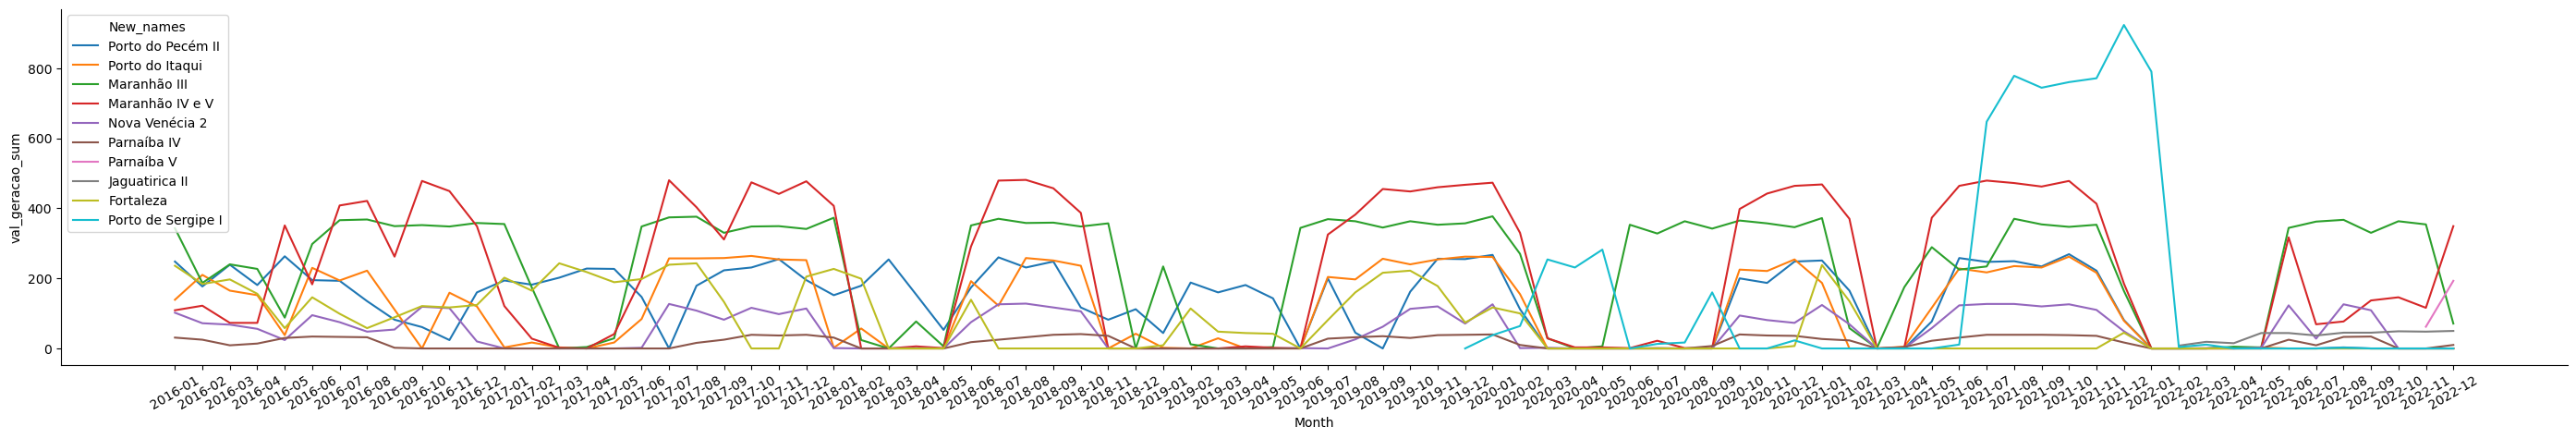

In [340]:
#monthly plot of ONS DATA THE TOTAL AMOUNT GENERATED EACH MONTH. Sum of Generated energy per month.
# This graphic show this value for all powerplants. Note that some 
fig, ax1 = plt.subplots(figsize=(35, 5))
g=sns.lineplot(x='Month', y='val_geracao_sum', hue='New_names', 
             data=ONS_df_clean_GB_monthly)
g.set_xticklabels(g.get_xticklabels(),rotation=30)
sns.despine(fig)

A clear seasonal behavior for the majority of the powerplants. (which is  expected due the organization of the Sistema Interligado Nacional(SIN), using thermal powerplants to fulfill the demand). 

## ONS UPTIME% PER MONTH 2016 to 2022 data.

I consider that an "active hour" when generation in that hour is above 0. And the concept of uptime is (active hours / total hours)*100

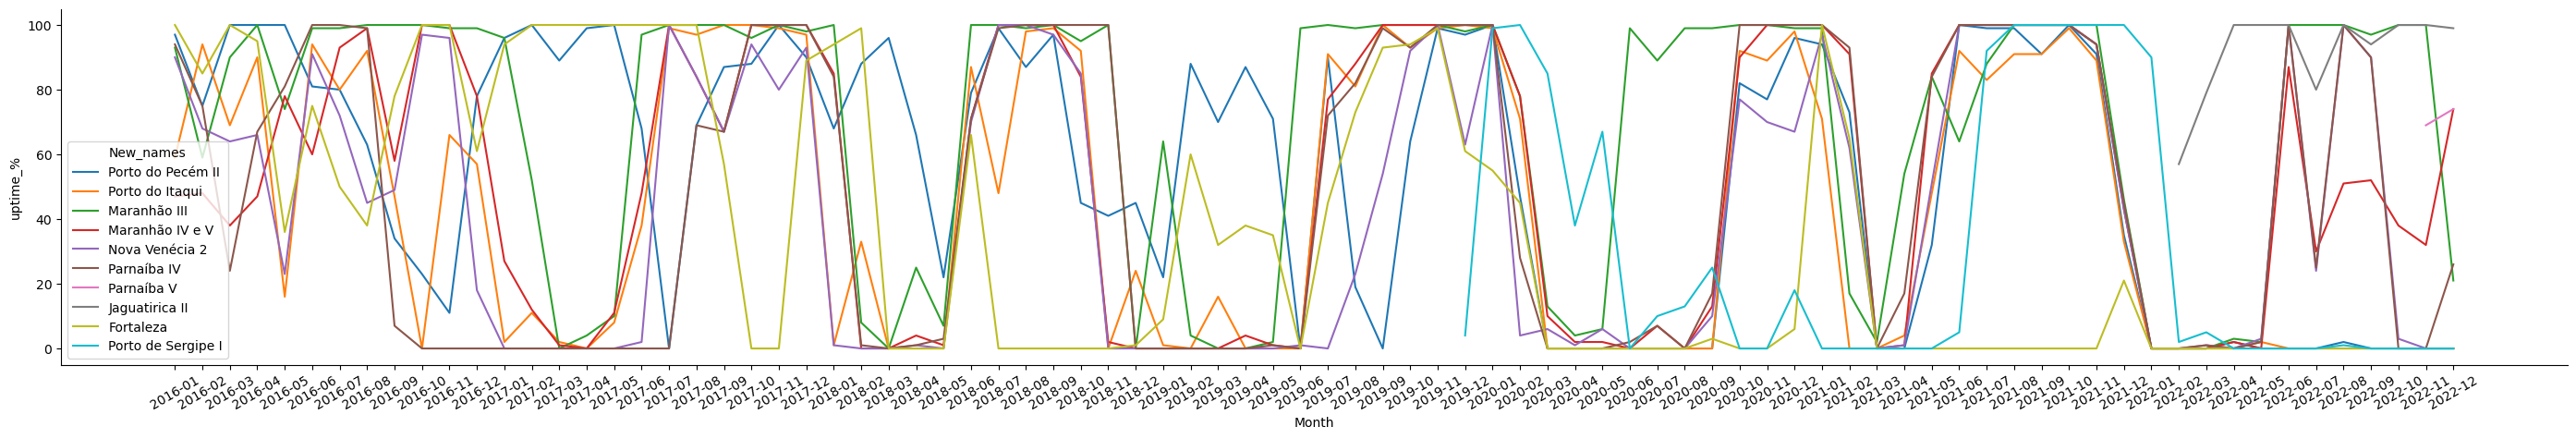

In [339]:
#monthly plot PERCENTAGE OF of Uptime each month (under the following assuption, given that generation at the hour is not zero

fig, ax1 = plt.subplots(figsize=(35, 5))
g=sns.lineplot(x='Month', y='uptime_%', hue='New_names', 
             data=ONS_df_clean_GB_monthly)
g.set_xticklabels(g.get_xticklabels(),rotation=30)
sns.despine(fig)

## Same plots but only showing  the plants for each consolidated class.

In [143]:
conso = 'Third-part LNG'

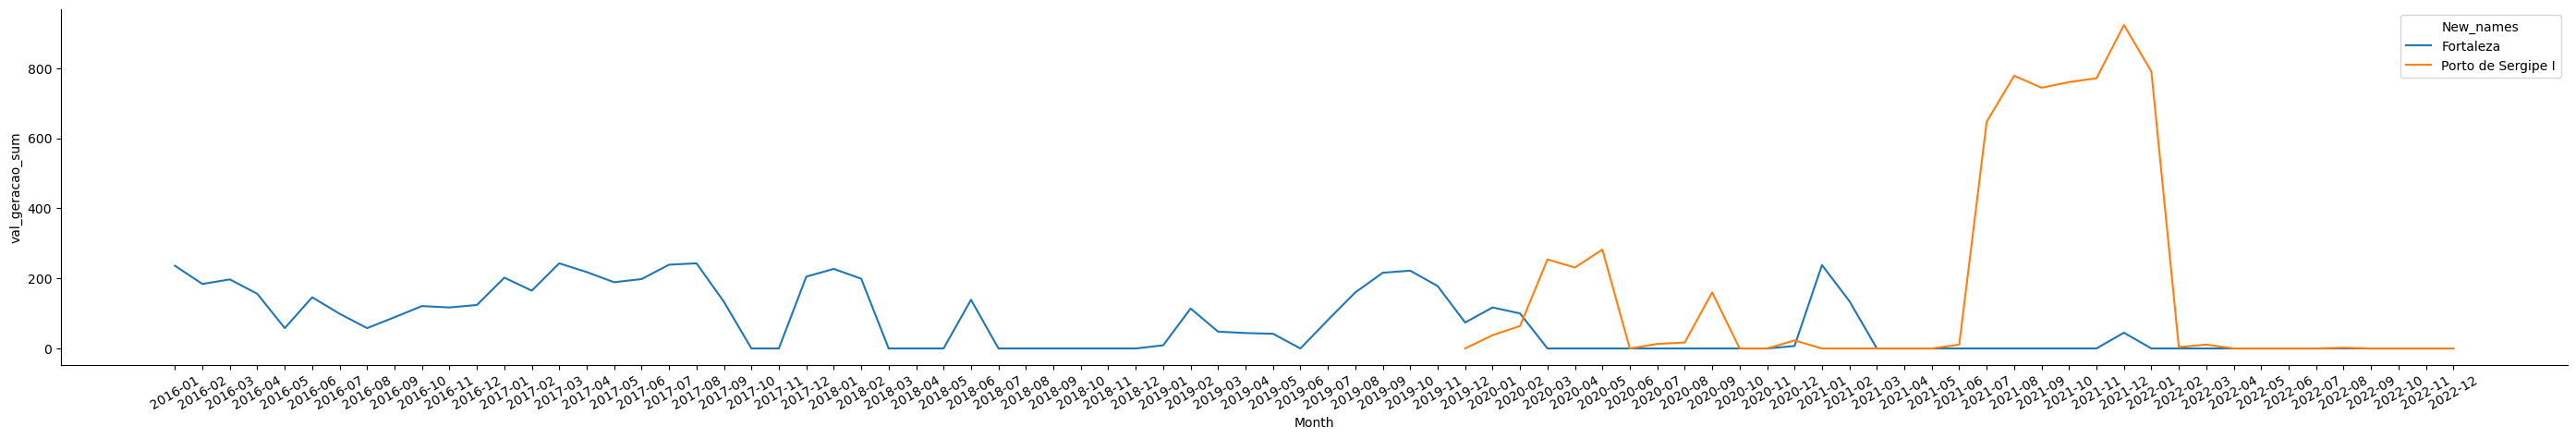

In [338]:
#monthly plot GENERATED
fig, ax1 = plt.subplots(figsize=(35, 5))
g=sns.lineplot(x='Month', y='val_geracao_sum', hue='New_names', 
             data=ONS_df_clean_GB_monthly[ONS_df_clean_GB_monthly["Consolidated"]==conso])
g.set_xticklabels(g.get_xticklabels(),rotation=30)
sns.despine(fig)

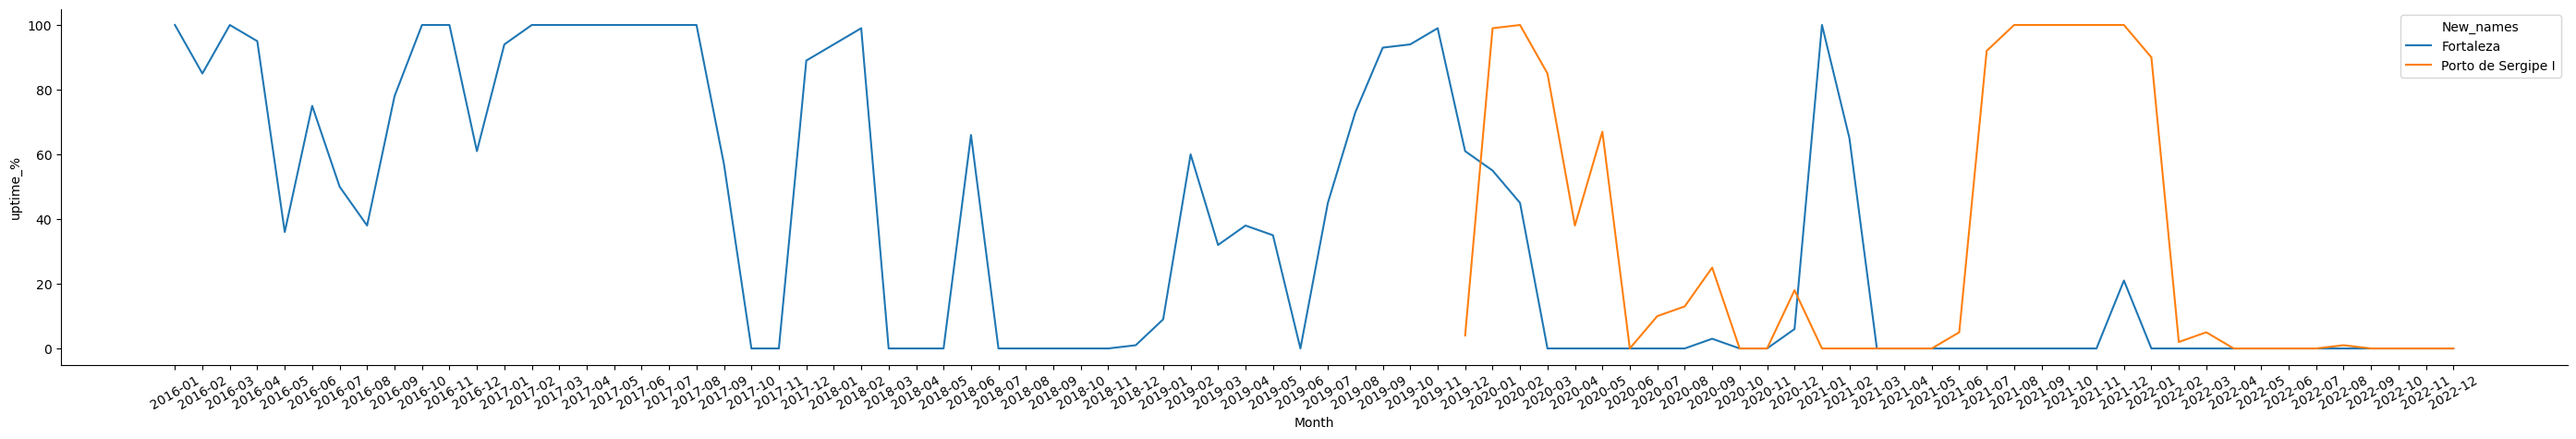

In [337]:
#monthly plot UPTIME
fig, ax1 = plt.subplots(figsize=(35, 5))
g=sns.lineplot(x='Month', y='uptime_%', hue='New_names', 
             data=ONS_df_clean_GB_monthly[ONS_df_clean_GB_monthly["Consolidated"]==conso])
g.set_xticklabels(g.get_xticklabels(),rotation=30)
sns.despine(fig)

In [363]:
conso = 'Coal Consolidated'

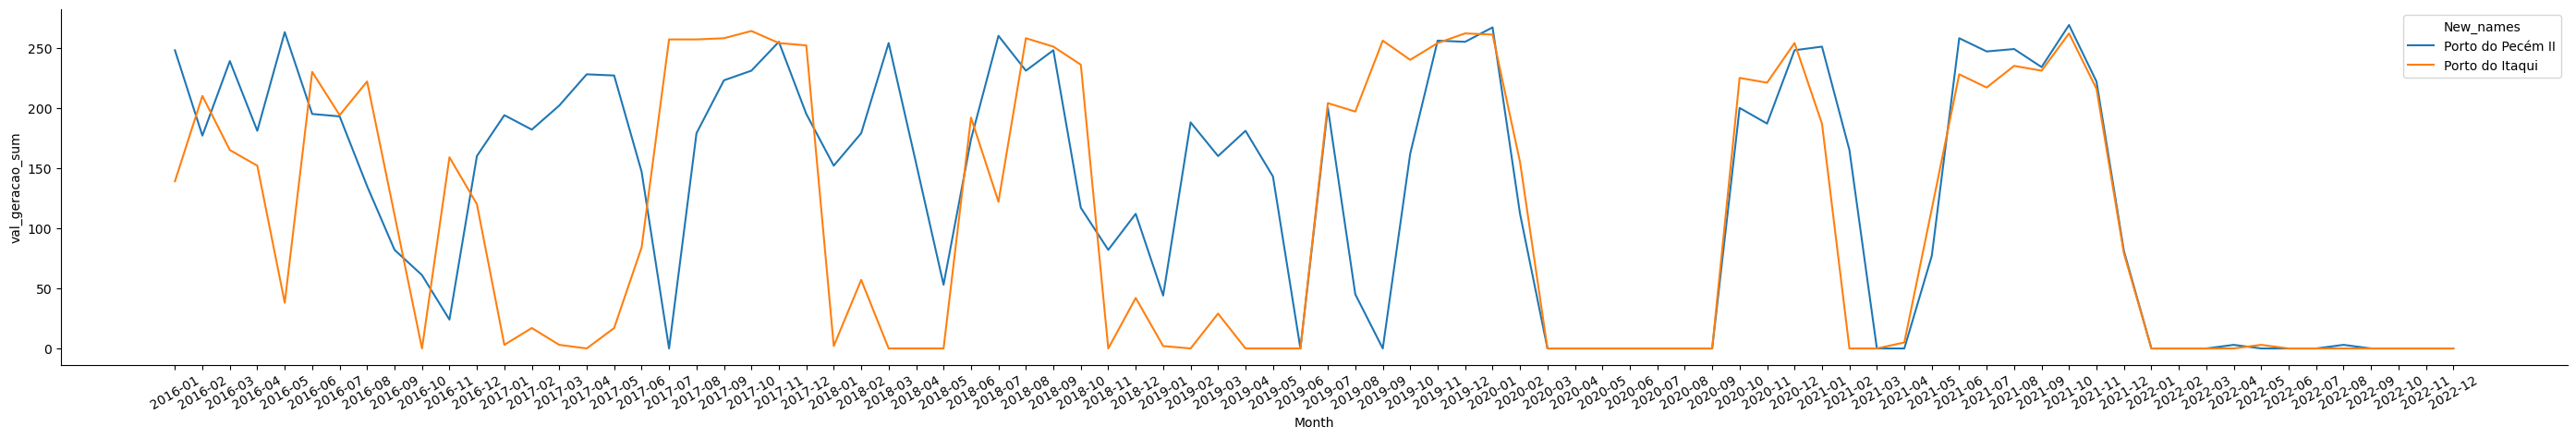

In [364]:
#monthly plot GENERATED
fig, ax1 = plt.subplots(figsize=(35, 5))
g=sns.lineplot(x='Month', y='val_geracao_sum', hue='New_names', 
             data=ONS_df_clean_GB_monthly[ONS_df_clean_GB_monthly["Consolidated"]==conso])
g.set_xticklabels(g.get_xticklabels(),rotation=30)
sns.despine(fig)

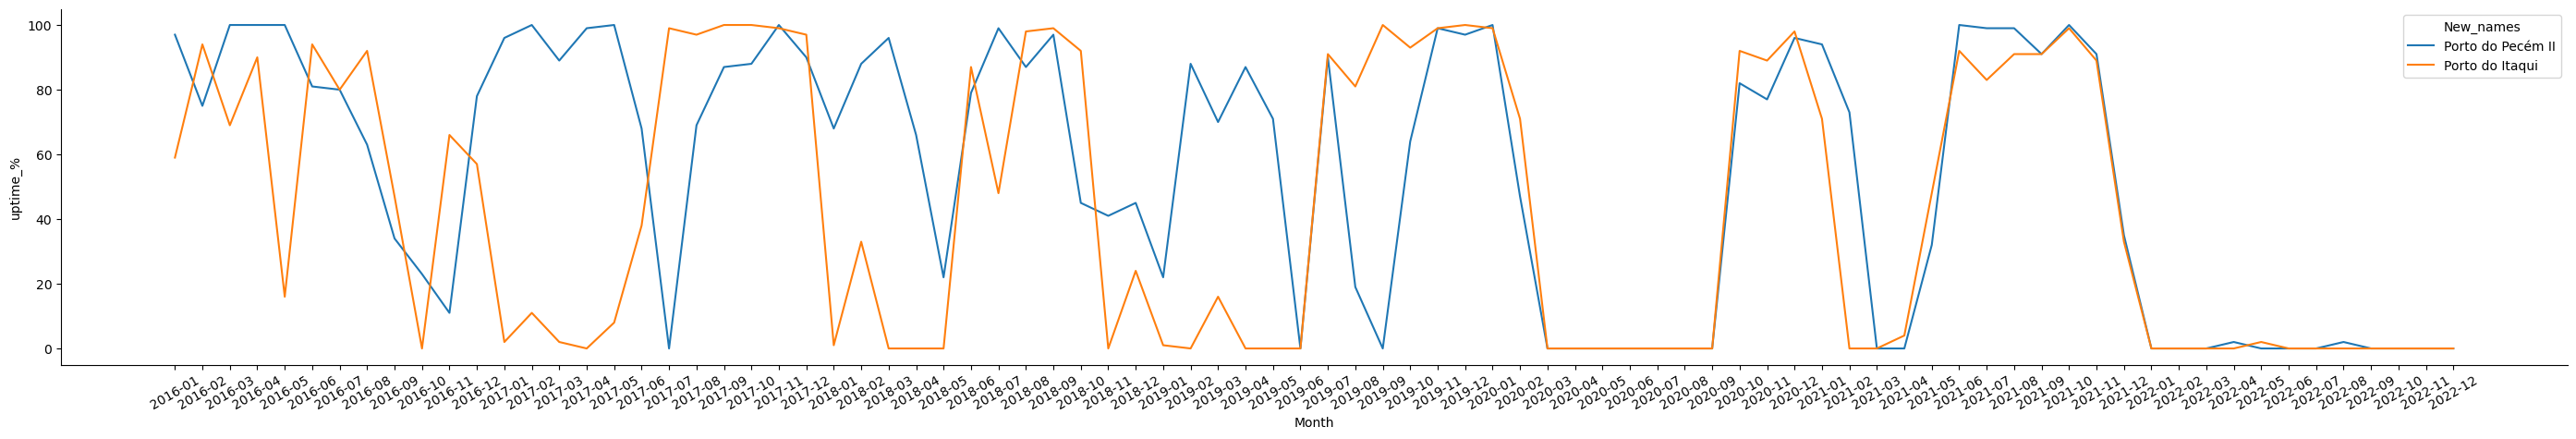

In [365]:
#monthly plot UPTIME
fig, ax1 = plt.subplots(figsize=(35, 5))
g=sns.lineplot(x='Month', y='uptime_%', hue='New_names', 
             data=ONS_df_clean_GB_monthly[ONS_df_clean_GB_monthly["Consolidated"]==conso])
g.set_xticklabels(g.get_xticklabels(),rotation=30)
sns.despine(fig)

In [366]:
conso = 'Parnaiba Consolidated'

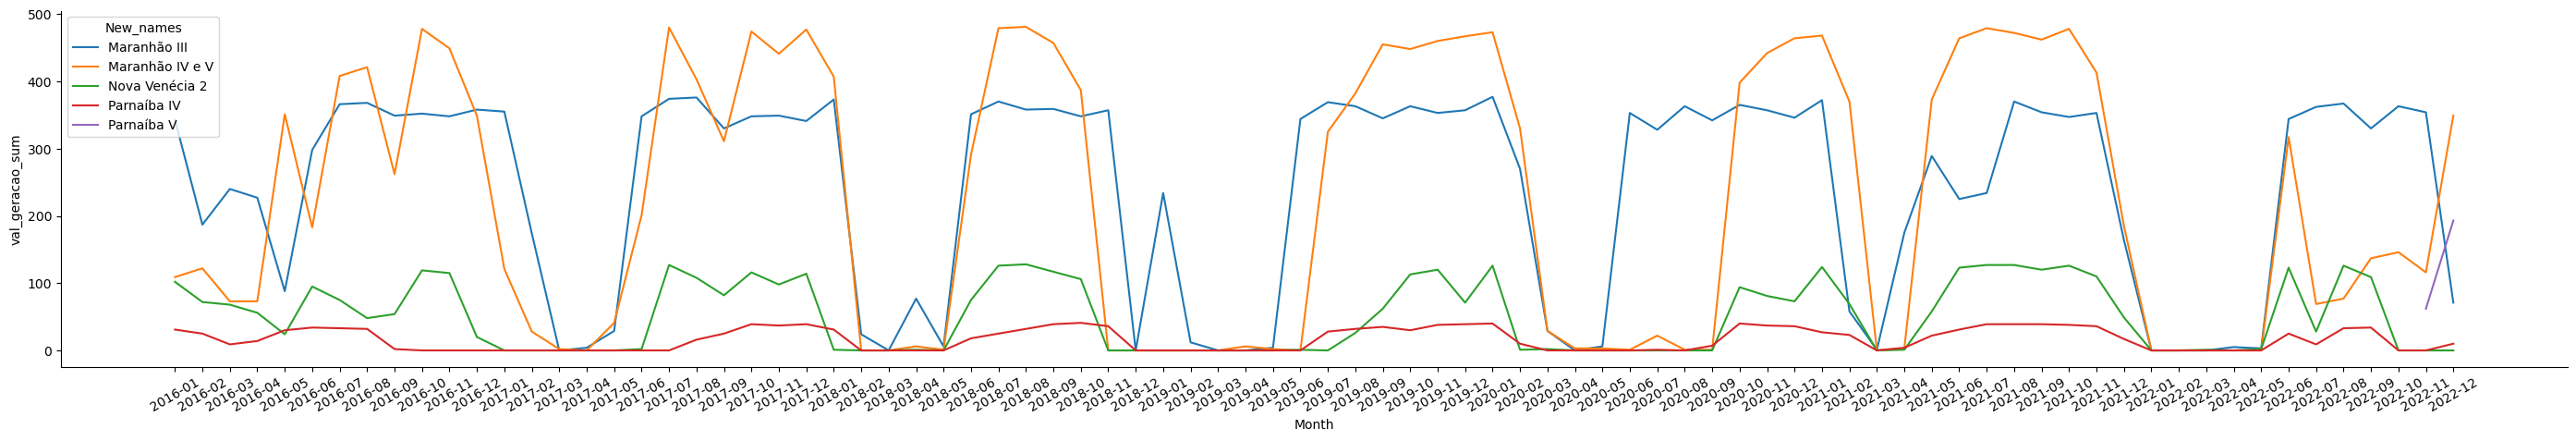

In [367]:
#monthly plot GENERATED
fig, ax1 = plt.subplots(figsize=(35, 5))
g=sns.lineplot(x='Month', y='val_geracao_sum', hue='New_names', 
             data=ONS_df_clean_GB_monthly[ONS_df_clean_GB_monthly["Consolidated"]==conso])
g.set_xticklabels(g.get_xticklabels(),rotation=30)
sns.despine(fig)

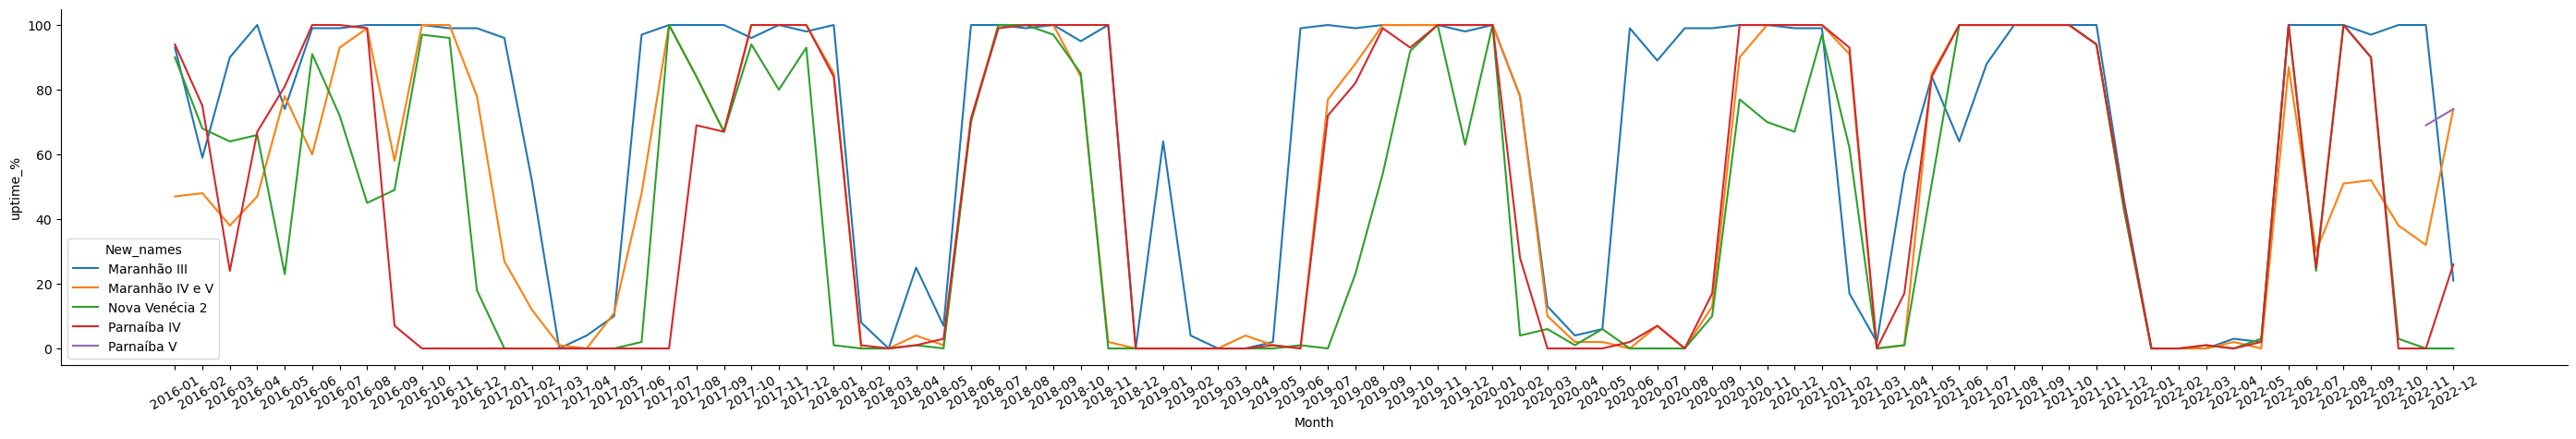

In [368]:
#monthly plot UPTIME
fig, ax1 = plt.subplots(figsize=(35, 5))
g=sns.lineplot(x='Month', y='uptime_%', hue='New_names', 
             data=ONS_df_clean_GB_monthly[ONS_df_clean_GB_monthly["Consolidated"]==conso])
g.set_xticklabels(g.get_xticklabels(),rotation=30)
sns.despine(fig)

In [369]:
conso = 'Roraima'

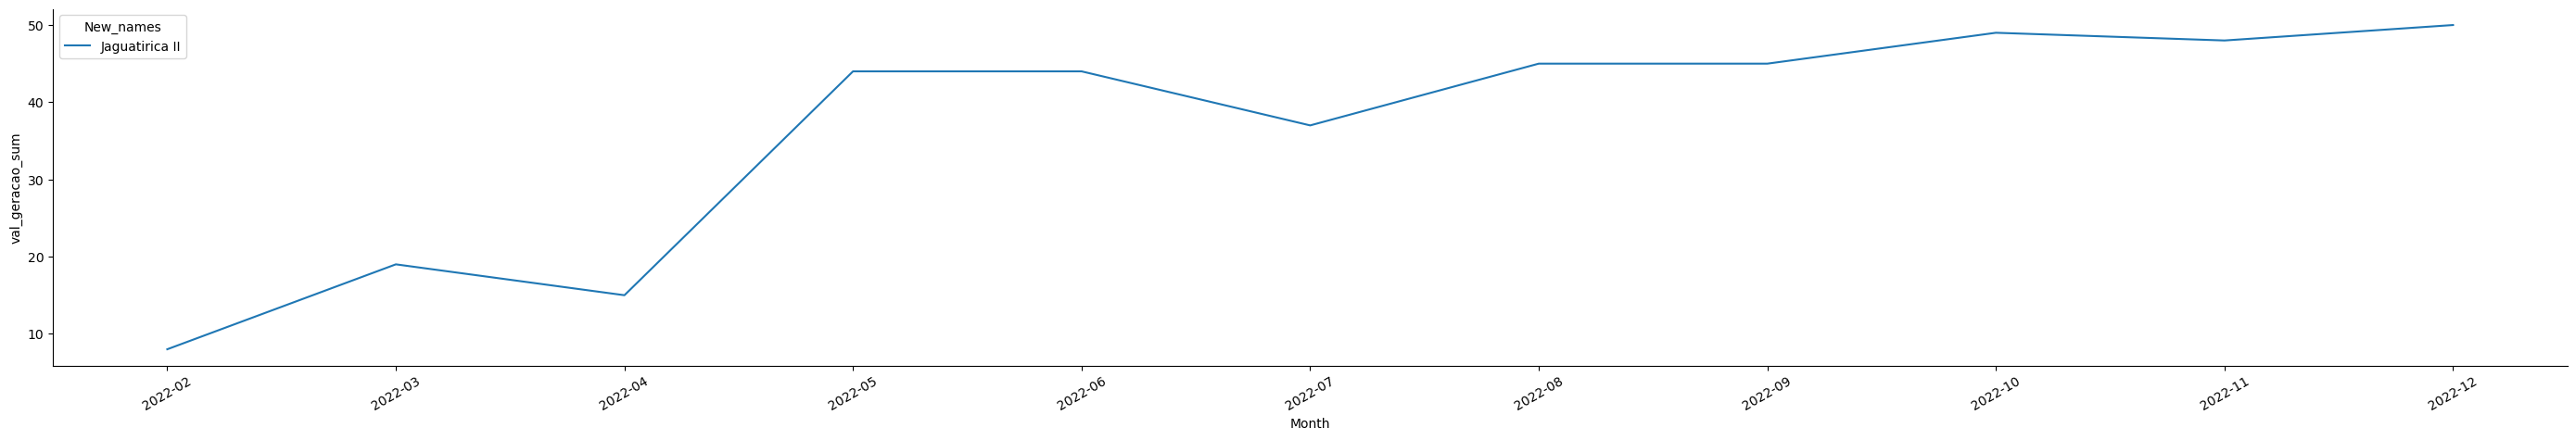

In [370]:
#monthly plot GENERATED
fig, ax1 = plt.subplots(figsize=(35, 5))
g=sns.lineplot(x='Month', y='val_geracao_sum', hue='New_names', 
             data=ONS_df_clean_GB_monthly[ONS_df_clean_GB_monthly["Consolidated"]==conso])
g.set_xticklabels(g.get_xticklabels(),rotation=30)
sns.despine(fig)

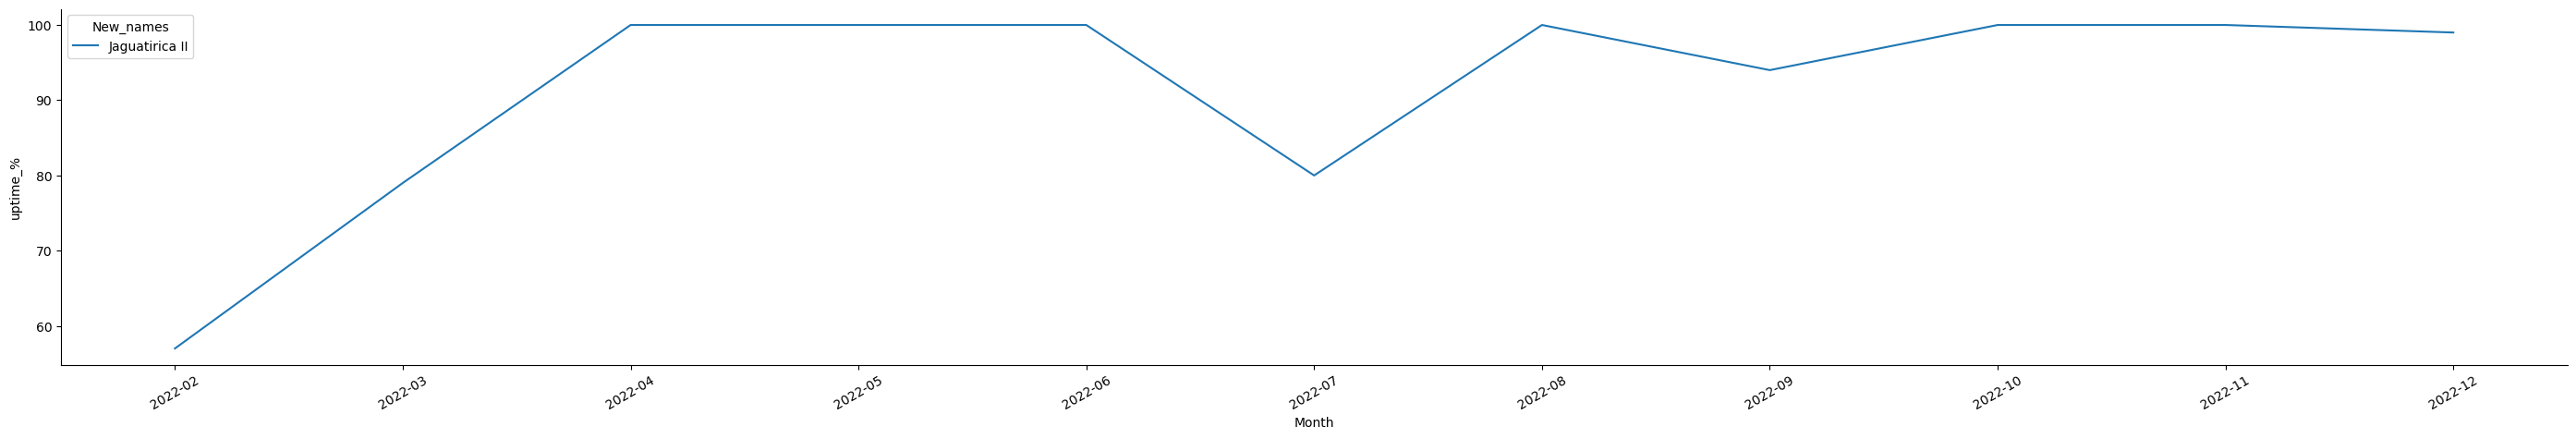

In [371]:
#monthly plot UPTIME
fig, ax1 = plt.subplots(figsize=(35, 5))
g=sns.lineplot(x='Month', y='uptime_%', hue='New_names', 
             data=ONS_df_clean_GB_monthly[ONS_df_clean_GB_monthly["Consolidated"]==conso])
g.set_xticklabels(g.get_xticklabels(),rotation=30)
sns.despine(fig)

## Comparing the value obtained from ONS to ENEVA's report for each powerplant

In [12]:
# merging the dataframes
dt_together = data_ENEVA_all[['New_names','Quarter','Disponibilidade (%)', 'Despacho (%)',
       'Geração Líquida (GWh)', 'Geração Bruta (GWh)', 'Geração para ACR (%)',
       'Geração para ACL (%)', 'Receita Variável Líquida (R$/MWh)1',
       'CVU (R$/MWh)2','unique_indentifier']].merge(ONS_df_clean_GB[['val_geracao_sum', 'active_hours','total_hours','uptime_%','unique_indentifier']], left_on=['unique_indentifier'], right_on=['unique_indentifier'])

In [166]:
list_names = dt_together["New_names"].unique()

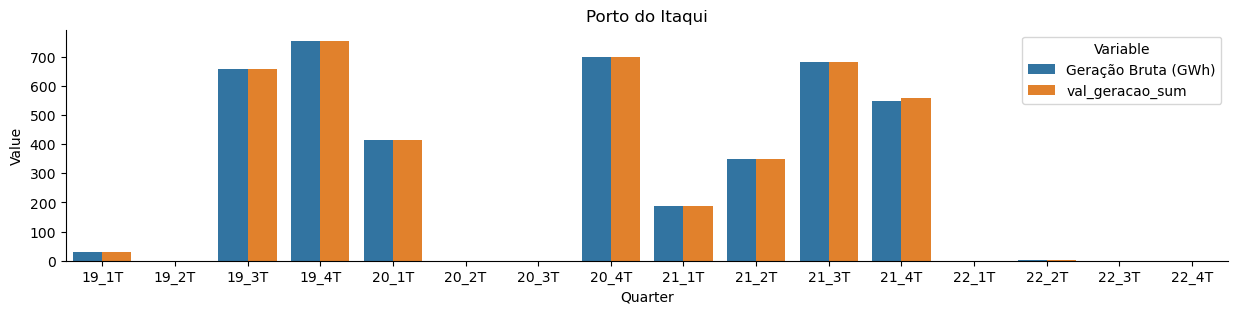

In [167]:
place = list_names[0]
fig, ax1 = plt.subplots(figsize=(15, 3))
tidy = dt_together.loc[(dt_together['Quarter'].isin(['19_1T','19_2T','19_3T','19_4T','20_1T','20_2T','20_3T','20_4T','21_1T','21_2T','21_3T','21_4T','22_1T','22_2T','22_3T','22_4T']))&(dt_together['New_names']==place),['Quarter','Geração Bruta (GWh)','val_geracao_sum']].melt(id_vars='Quarter').rename(columns=str.title)
sns.barplot(x='Quarter',y='Value', hue='Variable', data=tidy, ax=ax1,order=['19_1T','19_2T','19_3T','19_4T','20_1T','20_2T','20_3T','20_4T','21_1T','21_2T','21_3T','21_4T','22_1T','22_2T','22_3T','22_4T']).set(title=place)
sns.despine(fig)

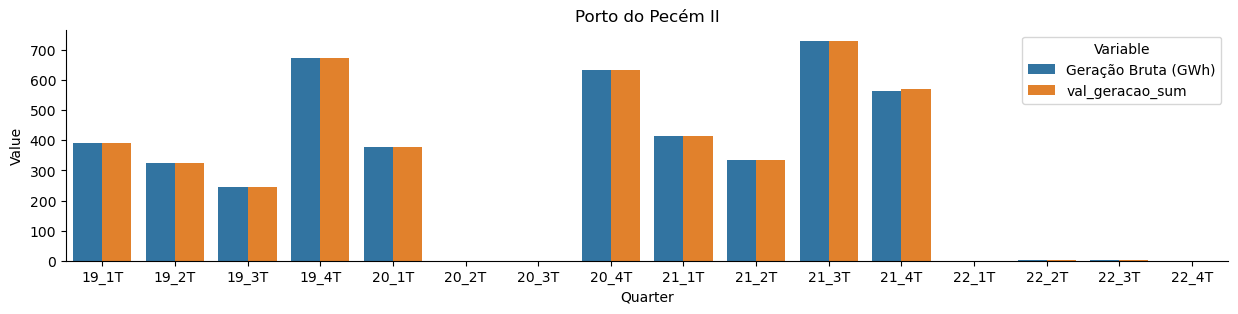

In [168]:
place = list_names[1]
fig, ax1 = plt.subplots(figsize=(15, 3))
tidy = dt_together.loc[(dt_together['Quarter'].isin(['19_1T','19_2T','19_3T','19_4T','20_1T','20_2T','20_3T','20_4T','21_1T','21_2T','21_3T','21_4T','22_1T','22_2T','22_3T','22_4T']))&(dt_together['New_names']==place),['Quarter','Geração Bruta (GWh)','val_geracao_sum']].melt(id_vars='Quarter').rename(columns=str.title)
sns.barplot(x='Quarter',y='Value', hue='Variable', data=tidy, ax=ax1,order=['19_1T','19_2T','19_3T','19_4T','20_1T','20_2T','20_3T','20_4T','21_1T','21_2T','21_3T','21_4T','22_1T','22_2T','22_3T','22_4T']).set(title=place)
sns.despine(fig)

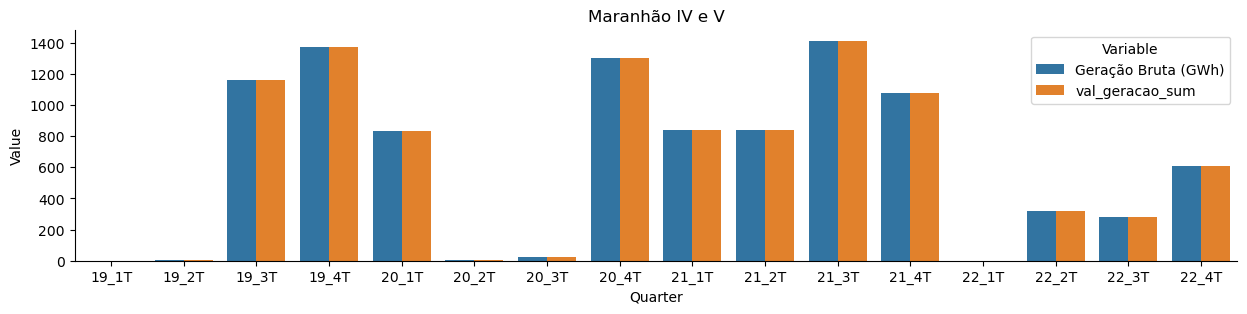

In [151]:
place = list_names[2]
fig, ax1 = plt.subplots(figsize=(15, 3))
tidy = dt_together.loc[(dt_together['Quarter'].isin(['19_1T','19_2T','19_3T','19_4T','20_1T','20_2T','20_3T','20_4T','21_1T','21_2T','21_3T','21_4T','22_1T','22_2T','22_3T','22_4T']))&(dt_together['New_names']==place),['Quarter','Geração Bruta (GWh)','val_geracao_sum']].melt(id_vars='Quarter').rename(columns=str.title)
sns.barplot(x='Quarter',y='Value', hue='Variable', data=tidy, ax=ax1,order=['19_1T','19_2T','19_3T','19_4T','20_1T','20_2T','20_3T','20_4T','21_1T','21_2T','21_3T','21_4T','22_1T','22_2T','22_3T','22_4T']).set(title=place)
sns.despine(fig)

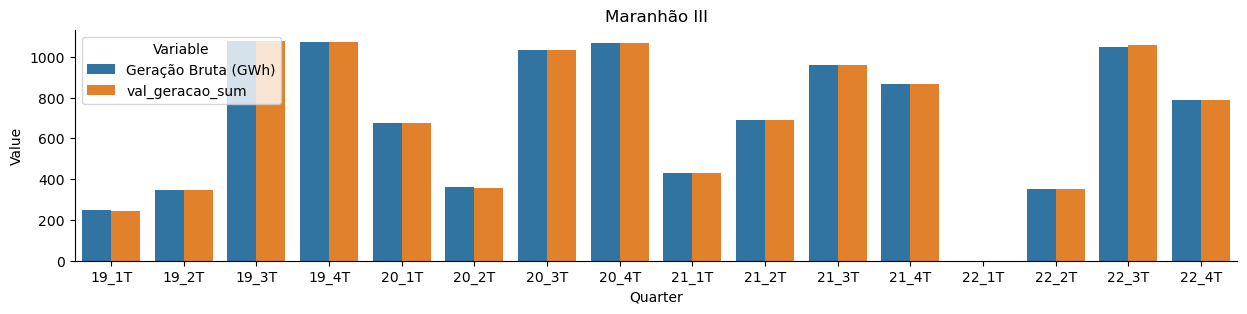

In [152]:
place = list_names[3]
fig, ax1 = plt.subplots(figsize=(15, 3))
tidy = dt_together.loc[(dt_together['Quarter'].isin(['19_1T','19_2T','19_3T','19_4T','20_1T','20_2T','20_3T','20_4T','21_1T','21_2T','21_3T','21_4T','22_1T','22_2T','22_3T','22_4T']))&(dt_together['New_names']==place),['Quarter','Geração Bruta (GWh)','val_geracao_sum']].melt(id_vars='Quarter').rename(columns=str.title)
sns.barplot(x='Quarter',y='Value', hue='Variable', data=tidy, ax=ax1,order=['19_1T','19_2T','19_3T','19_4T','20_1T','20_2T','20_3T','20_4T','21_1T','21_2T','21_3T','21_4T','22_1T','22_2T','22_3T','22_4T']).set(title=place)
sns.despine(fig)

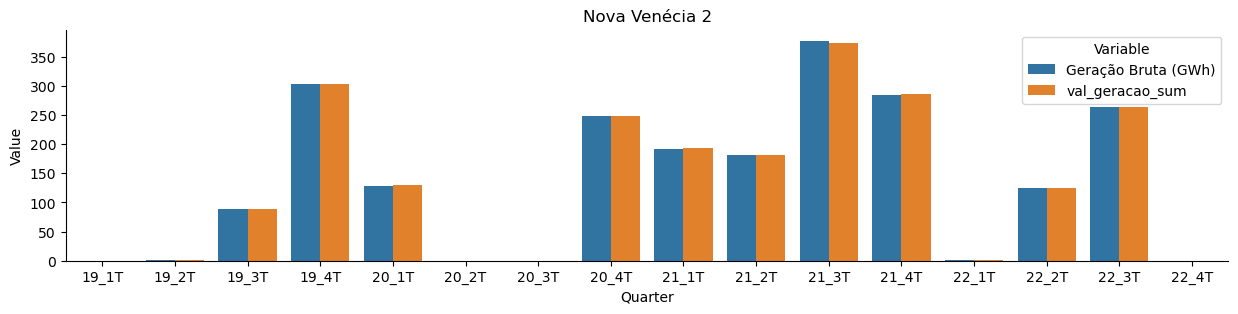

In [153]:
place = list_names[4]
fig, ax1 = plt.subplots(figsize=(15, 3))
tidy = dt_together.loc[(dt_together['Quarter'].isin(['19_1T','19_2T','19_3T','19_4T','20_1T','20_2T','20_3T','20_4T','21_1T','21_2T','21_3T','21_4T','22_1T','22_2T','22_3T','22_4T']))&(dt_together['New_names']==place),['Quarter','Geração Bruta (GWh)','val_geracao_sum']].melt(id_vars='Quarter').rename(columns=str.title)
sns.barplot(x='Quarter',y='Value', hue='Variable', data=tidy, ax=ax1,order=['19_1T','19_2T','19_3T','19_4T','20_1T','20_2T','20_3T','20_4T','21_1T','21_2T','21_3T','21_4T','22_1T','22_2T','22_3T','22_4T']).set(title=place)
sns.despine(fig)

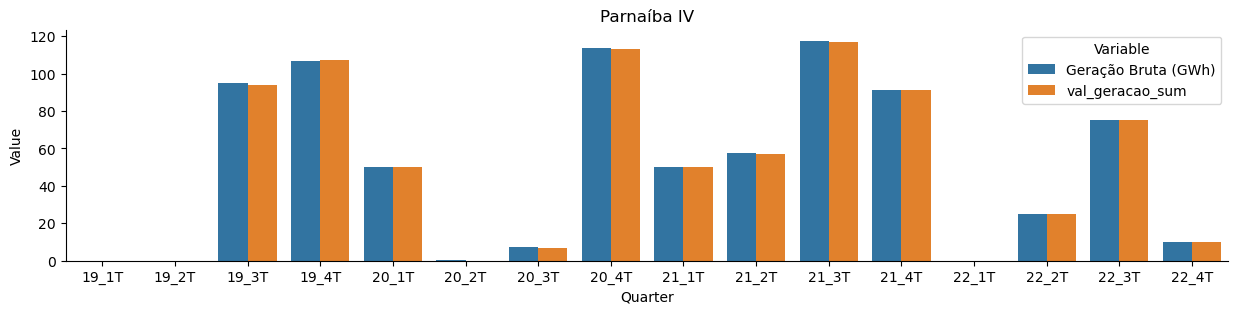

In [154]:
place = list_names[5]
fig, ax1 = plt.subplots(figsize=(15, 3))
tidy = dt_together.loc[(dt_together['Quarter'].isin(['19_1T','19_2T','19_3T','19_4T','20_1T','20_2T','20_3T','20_4T','21_1T','21_2T','21_3T','21_4T','22_1T','22_2T','22_3T','22_4T']))&(dt_together['New_names']==place),['Quarter','Geração Bruta (GWh)','val_geracao_sum']].melt(id_vars='Quarter').rename(columns=str.title)
sns.barplot(x='Quarter',y='Value', hue='Variable', data=tidy, ax=ax1,order=['19_1T','19_2T','19_3T','19_4T','20_1T','20_2T','20_3T','20_4T','21_1T','21_2T','21_3T','21_4T','22_1T','22_2T','22_3T','22_4T']).set(title=place)
sns.despine(fig)

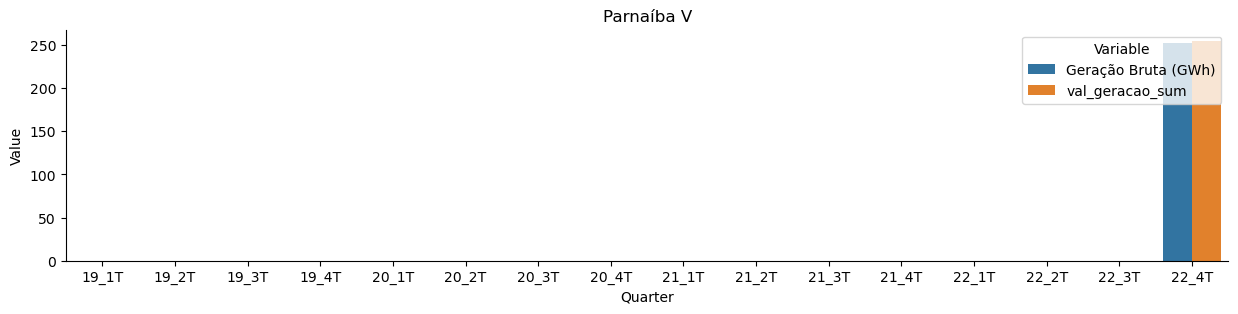

In [155]:
place = list_names[6]
fig, ax1 = plt.subplots(figsize=(15, 3))
tidy = dt_together.loc[(dt_together['Quarter'].isin(['19_1T','19_2T','19_3T','19_4T','20_1T','20_2T','20_3T','20_4T','21_1T','21_2T','21_3T','21_4T','22_1T','22_2T','22_3T','22_4T']))&(dt_together['New_names']==place),['Quarter','Geração Bruta (GWh)','val_geracao_sum']].melt(id_vars='Quarter').rename(columns=str.title)
sns.barplot(x='Quarter',y='Value', hue='Variable', data=tidy, ax=ax1,order=['19_1T','19_2T','19_3T','19_4T','20_1T','20_2T','20_3T','20_4T','21_1T','21_2T','21_3T','21_4T','22_1T','22_2T','22_3T','22_4T']).set(title=place)
sns.despine(fig)

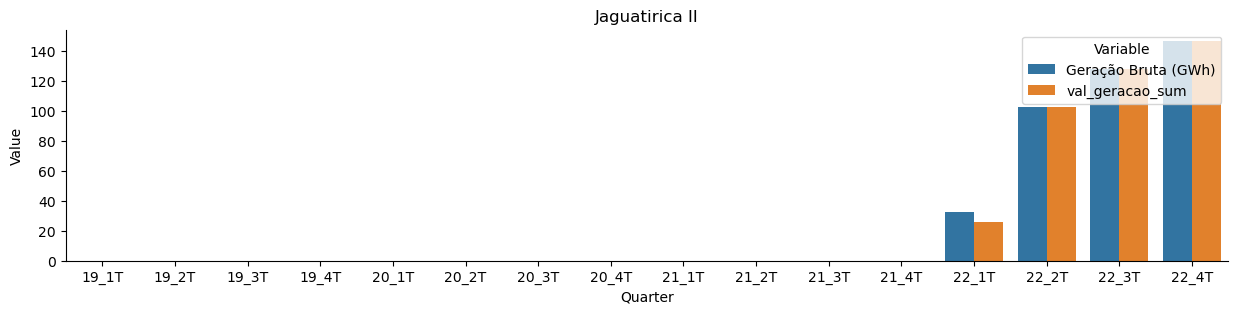

In [156]:
place = list_names[7]
fig, ax1 = plt.subplots(figsize=(15, 3))
tidy = dt_together.loc[(dt_together['Quarter'].isin(['19_1T','19_2T','19_3T','19_4T','20_1T','20_2T','20_3T','20_4T','21_1T','21_2T','21_3T','21_4T','22_1T','22_2T','22_3T','22_4T']))&(dt_together['New_names']==place),['Quarter','Geração Bruta (GWh)','val_geracao_sum']].melt(id_vars='Quarter').rename(columns=str.title)
sns.barplot(x='Quarter',y='Value', hue='Variable', data=tidy, ax=ax1,order=['19_1T','19_2T','19_3T','19_4T','20_1T','20_2T','20_3T','20_4T','21_1T','21_2T','21_3T','21_4T','22_1T','22_2T','22_3T','22_4T']).set(title=place)
sns.despine(fig)

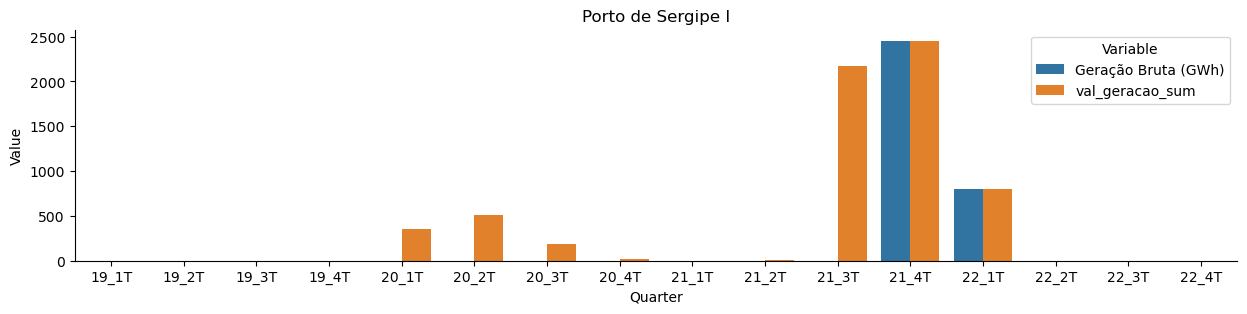

In [157]:
place = list_names[8]
fig, ax1 = plt.subplots(figsize=(15, 3))
tidy = dt_together.loc[(dt_together['Quarter'].isin(['19_1T','19_2T','19_3T','19_4T','20_1T','20_2T','20_3T','20_4T','21_1T','21_2T','21_3T','21_4T','22_1T','22_2T','22_3T','22_4T']))&(dt_together['New_names']==place),['Quarter','Geração Bruta (GWh)','val_geracao_sum']].melt(id_vars='Quarter').rename(columns=str.title)
sns.barplot(x='Quarter',y='Value', hue='Variable', data=tidy, ax=ax1,order=['19_1T','19_2T','19_3T','19_4T','20_1T','20_2T','20_3T','20_4T','21_1T','21_2T','21_3T','21_4T','22_1T','22_2T','22_3T','22_4T']).set(title=place)
sns.despine(fig)

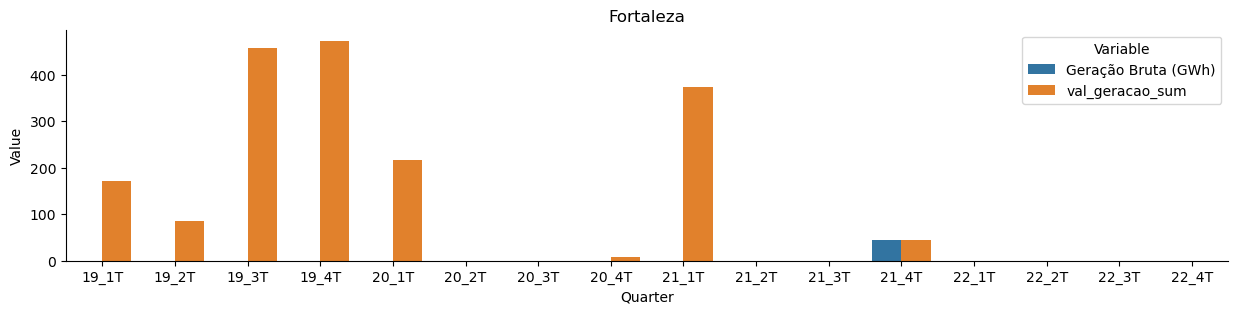

In [158]:
place = list_names[9]
fig, ax1 = plt.subplots(figsize=(15, 3))
tidy = dt_together.loc[(dt_together['Quarter'].isin(['19_1T','19_2T','19_3T','19_4T','20_1T','20_2T','20_3T','20_4T','21_1T','21_2T','21_3T','21_4T','22_1T','22_2T','22_3T','22_4T']))&(dt_together['New_names']==place),['Quarter','Geração Bruta (GWh)','val_geracao_sum']].melt(id_vars='Quarter').rename(columns=str.title)
sns.barplot(x='Quarter',y='Value', hue='Variable', data=tidy, ax=ax1,order=['19_1T','19_2T','19_3T','19_4T','20_1T','20_2T','20_3T','20_4T','21_1T','21_2T','21_3T','21_4T','22_1T','22_2T','22_3T','22_4T']).set(title=place)
sns.despine(fig)

## Doing the same comparison, but for the generated sum of all powerplants.

In [13]:
## using a groupby  on the ONS dataframe to aggregate the data by the monthly.
dt_together_all = dt_together.groupby('Quarter').agg(total_val_geracao_ONS=('val_geracao_sum', sum),
                                                     total_active_hours_ONS = ('active_hours', sum),
                                                     total_total_hours_ONS = ('total_hours', sum),
                                                    total_geracao_bruta_ENEVA=('Geração Bruta (GWh)', sum)).reset_index()

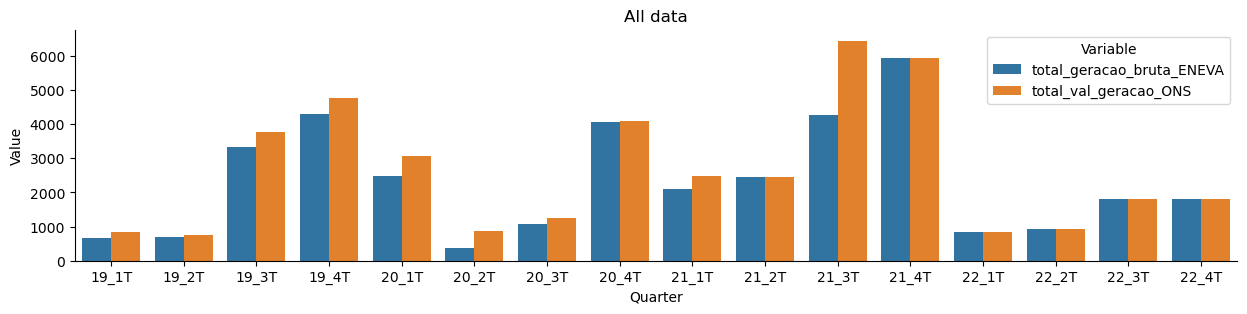

In [233]:
fig, ax1 = plt.subplots(figsize=(15, 3))
tidy = dt_together_all.loc[(dt_together_all['Quarter'].isin(['19_1T','19_2T','19_3T','19_4T','20_1T','20_2T','20_3T','20_4T','21_1T','21_2T','21_3T','21_4T','22_1T','22_2T','22_3T','22_4T'])),['Quarter','total_geracao_bruta_ENEVA','total_val_geracao_ONS']].melt(id_vars='Quarter').rename(columns=str.title)
sns.barplot(x='Quarter',y='Value', hue='Variable', data=tidy, ax=ax1,order=['19_1T','19_2T','19_3T','19_4T','20_1T','20_2T','20_3T','20_4T','21_1T','21_2T','21_3T','21_4T','22_1T','22_2T','22_3T','22_4T']).set(title='All data')
sns.despine(fig)

In [17]:
dt_together_all['Real_Error'] = dt_together_all['total_geracao_bruta_ENEVA'] - dt_together_all['total_val_geracao_ONS']
dt_together_all['quarter_uptime'] = (100*dt_together_all['total_active_hours_ONS']/dt_together_all['total_total_hours_ONS']).round(2)
dt_together_all.drop(columns=['total_active_hours_ONS', 'total_total_hours_ONS'],inplace=True)

## Observation
Observe that some of the power plants are not present in both databases. Besides that, all the power plants that have larger historical data show that the ONS data seems like a good measurement of Eneva's quarterly production report.

In [9]:
dt_together.drop(columns=['active_hours','total_hours'],inplace=True)

## For further analysis I plotted the correlation map for each powerplant

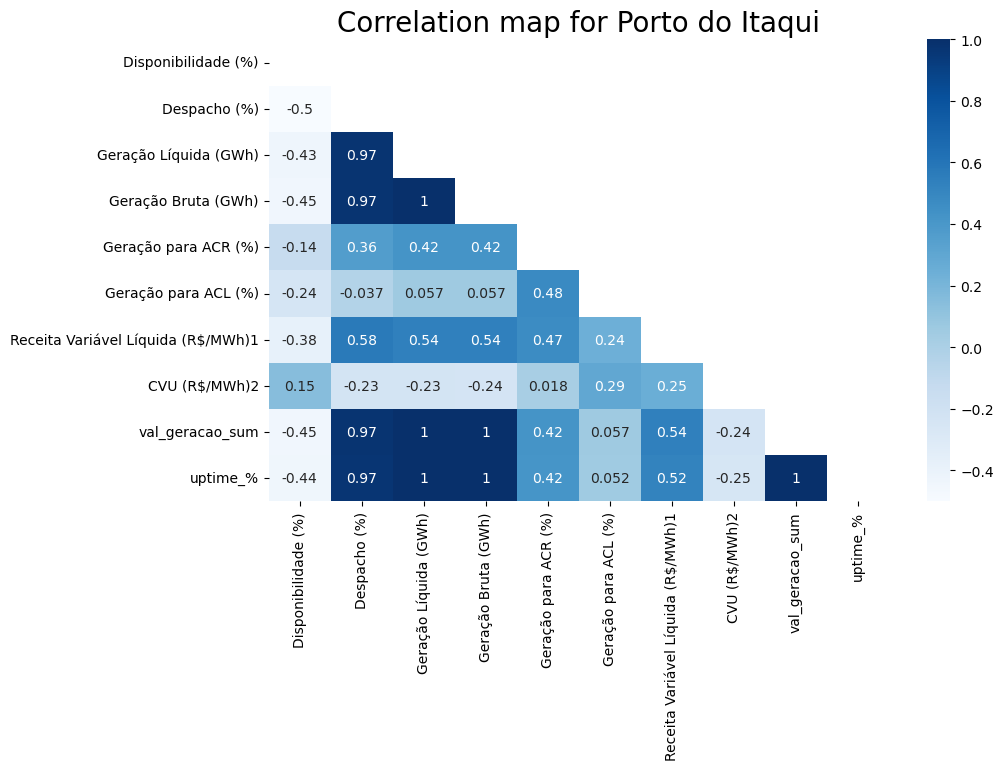

In [343]:
## CORRELATION FOR EACH POWERPLANT
powerplant_name = list_names[0]
corr = dt_together[dt_together['New_names']==powerplant_name].corr(method='spearman') #{‘pearson’, ‘kendall’, ‘spearman’} 
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(10, 6))
sns.heatmap(corr, mask=mask ,cmap="Blues", annot=True)
plt.title('Correlation map for ' + powerplant_name, fontsize = 20)
plt.show();

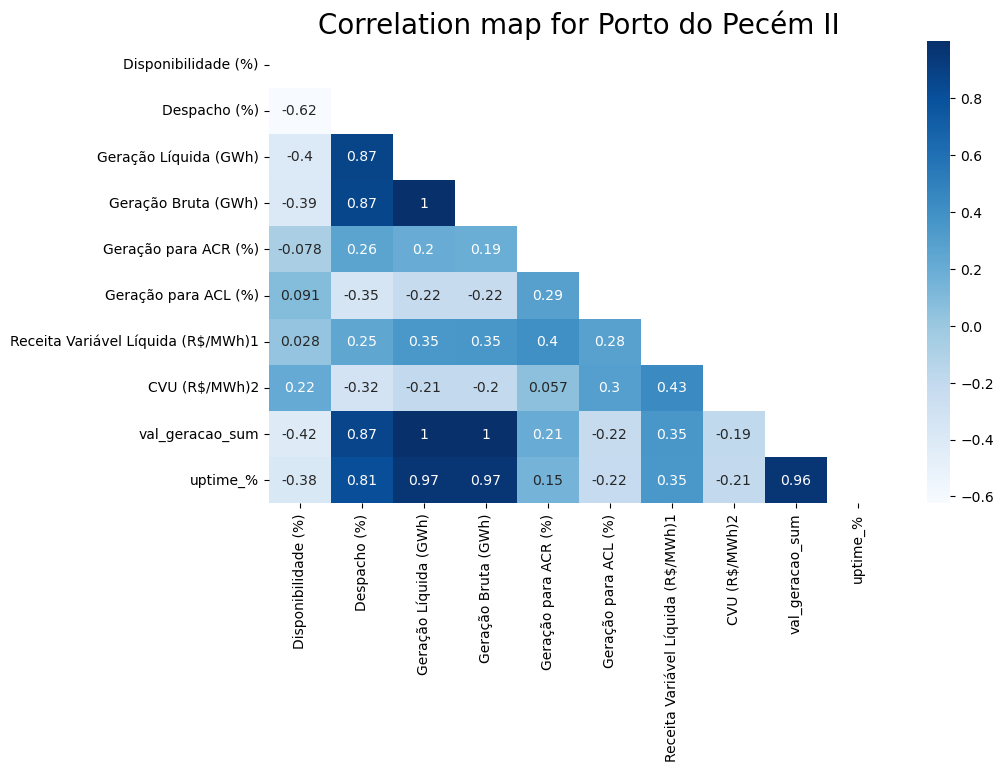

In [344]:
## CORRELATION FOR EACH POWERPLANT
powerplant_name = list_names[1]
corr = dt_together[dt_together['New_names']==powerplant_name].corr(method='spearman') #{‘pearson’, ‘kendall’, ‘spearman’} 
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(10, 6))
sns.heatmap(corr, mask=mask ,cmap="Blues", annot=True)
plt.title('Correlation map for ' + powerplant_name, fontsize = 20)
plt.show();

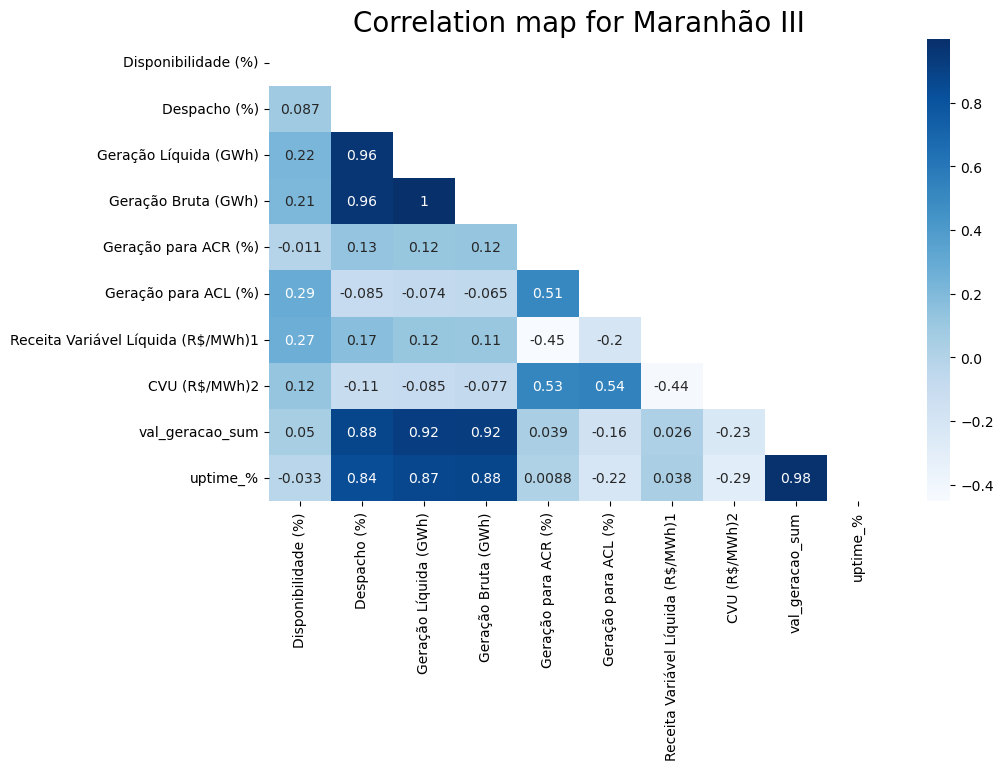

In [345]:
## CORRELATION FOR EACH POWERPLANT
powerplant_name = list_names[3]
corr = dt_together[dt_together['New_names']==powerplant_name].corr(method='spearman') #{‘pearson’, ‘kendall’, ‘spearman’} 
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(10, 6))
sns.heatmap(corr, mask=mask ,cmap="Blues", annot=True)
plt.title('Correlation map for ' + powerplant_name, fontsize = 20)
plt.show();

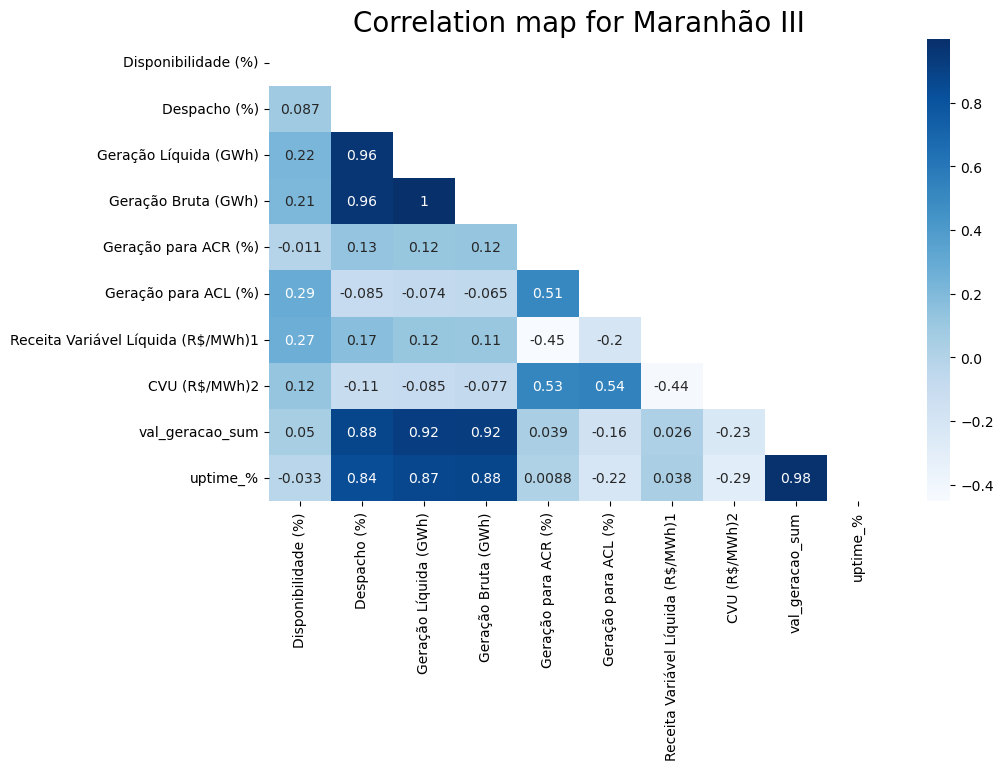

In [346]:
## CORRELATION FOR EACH POWERPLANT
powerplant_name = list_names[3]
corr = dt_together[dt_together['New_names']==powerplant_name].corr(method='spearman') #{‘pearson’, ‘kendall’, ‘spearman’} 
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(10, 6))
sns.heatmap(corr, mask=mask ,cmap="Blues", annot=True)
plt.title('Correlation map for ' + powerplant_name, fontsize = 20)
plt.show();

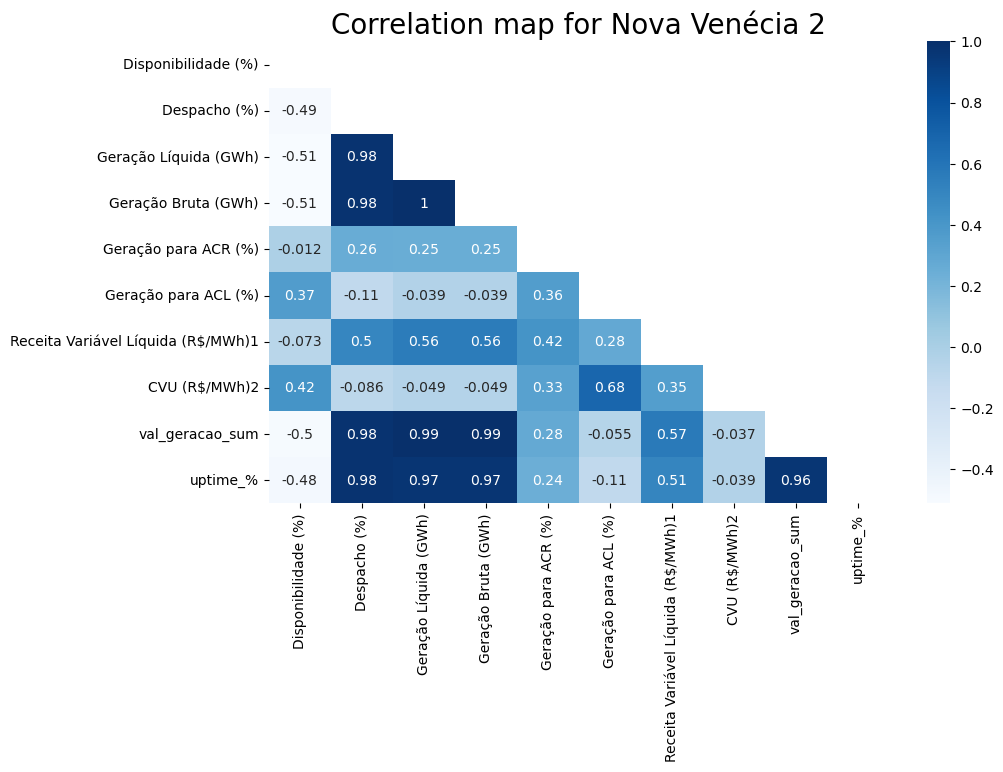

In [347]:
## CORRELATION FOR EACH POWERPLANT
powerplant_name = list_names[4]
corr = dt_together[dt_together['New_names']==powerplant_name].corr(method='spearman') #{‘pearson’, ‘kendall’, ‘spearman’} 
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(10, 6))
sns.heatmap(corr, mask=mask ,cmap="Blues", annot=True)
plt.title('Correlation map for ' + powerplant_name, fontsize = 20)
plt.show();

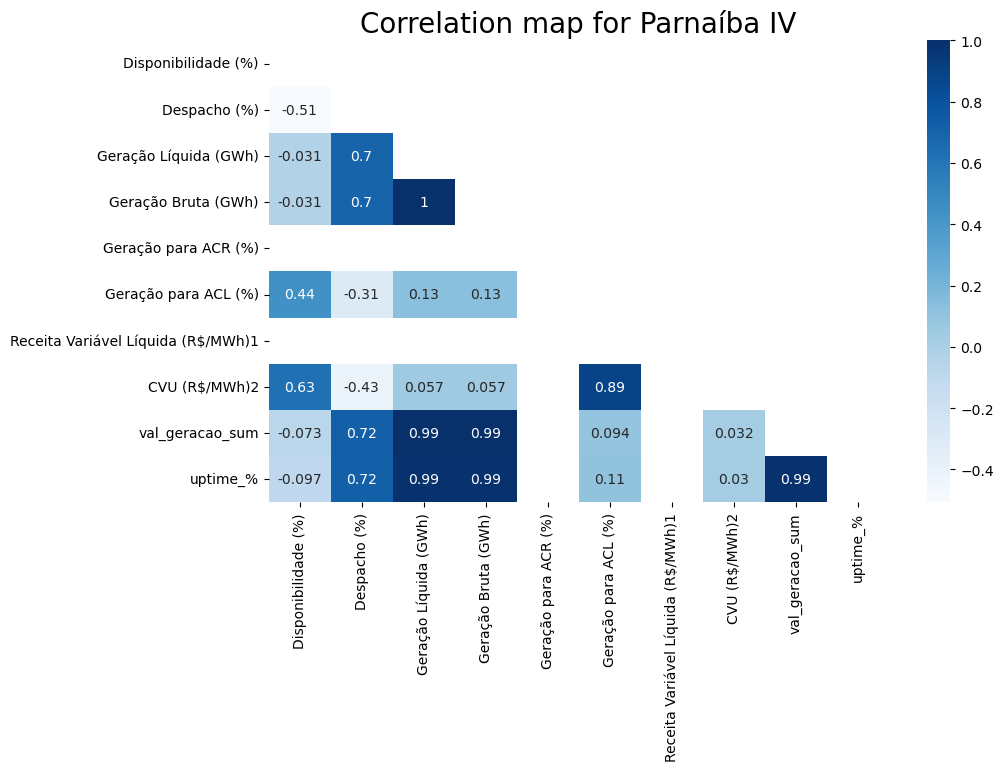

In [348]:
## CORRELATION FOR EACH POWERPLANT
powerplant_name = list_names[5]
corr = dt_together[dt_together['New_names']==powerplant_name].corr(method='spearman') #{‘pearson’, ‘kendall’, ‘spearman’} 
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(10, 6))
sns.heatmap(corr, mask=mask ,cmap="Blues", annot=True)
plt.title('Correlation map for ' + powerplant_name, fontsize = 20)
plt.show();

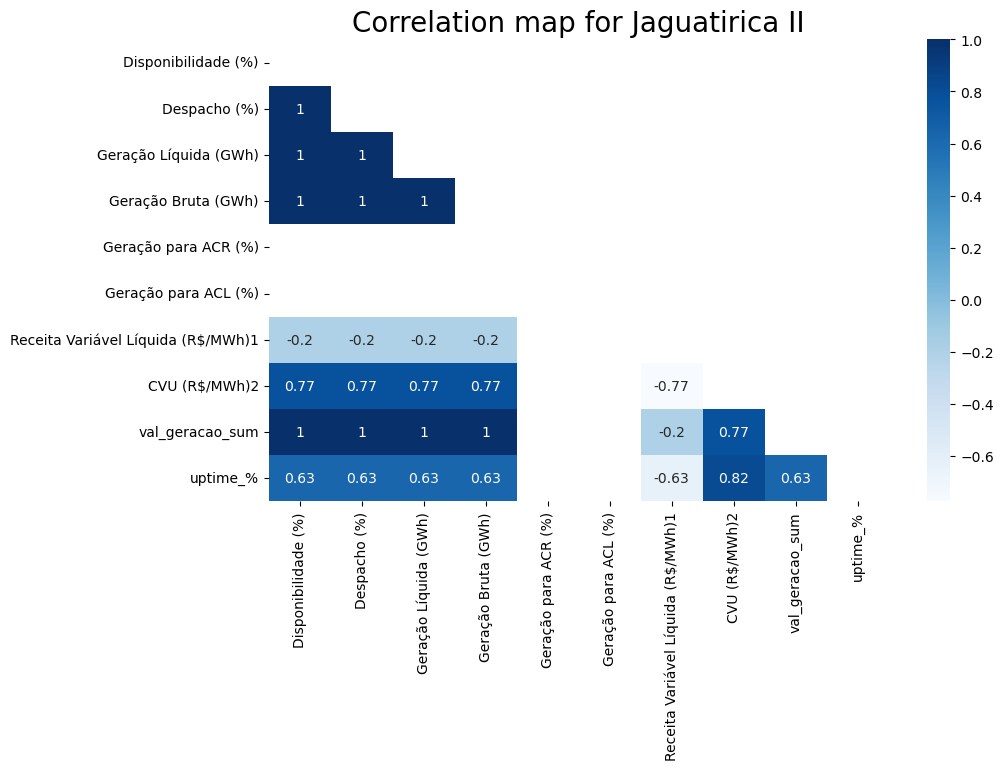

In [349]:
## CORRELATION FOR EACH POWERPLANT
powerplant_name = list_names[7]
corr = dt_together[dt_together['New_names']==powerplant_name].corr(method='spearman') #{‘pearson’, ‘kendall’, ‘spearman’} 
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(10, 6))
sns.heatmap(corr, mask=mask ,cmap="Blues", annot=True)
plt.title('Correlation map for ' + powerplant_name, fontsize = 20)
plt.show();

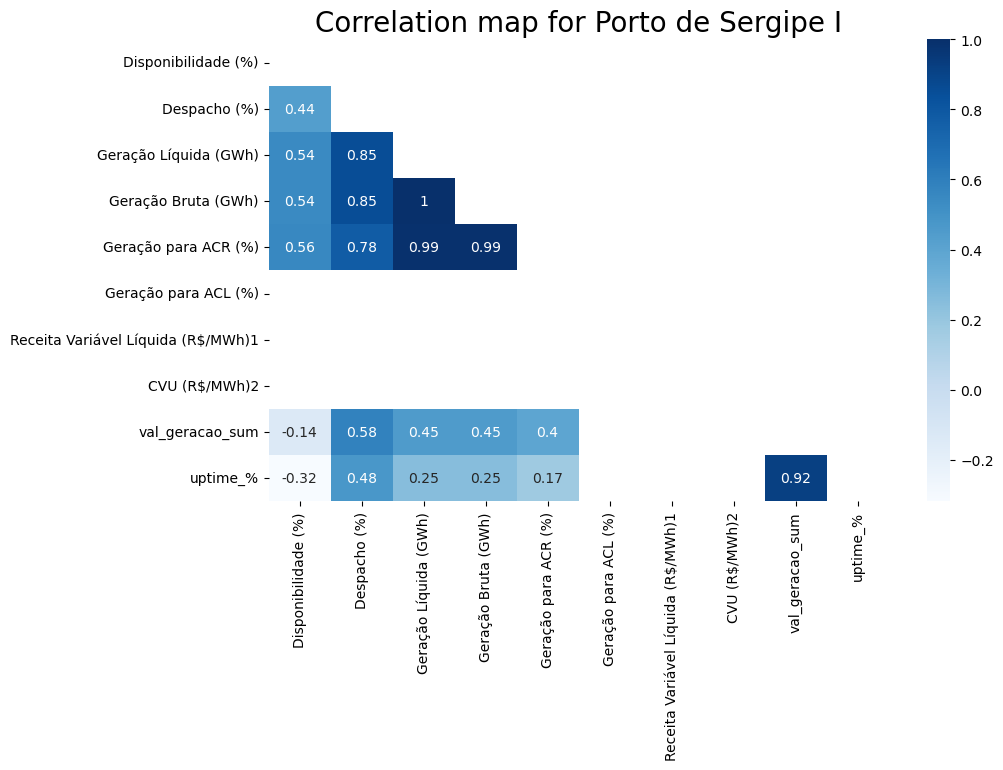

In [350]:
## CORRELATION FOR EACH POWERPLANT
powerplant_name = list_names[8]
corr = dt_together[dt_together['New_names']==powerplant_name].corr(method='spearman') #{‘pearson’, ‘kendall’, ‘spearman’} 
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(10, 6))
sns.heatmap(corr, mask=mask ,cmap="Blues", annot=True)
plt.title('Correlation map for ' + powerplant_name, fontsize = 20)
plt.show();

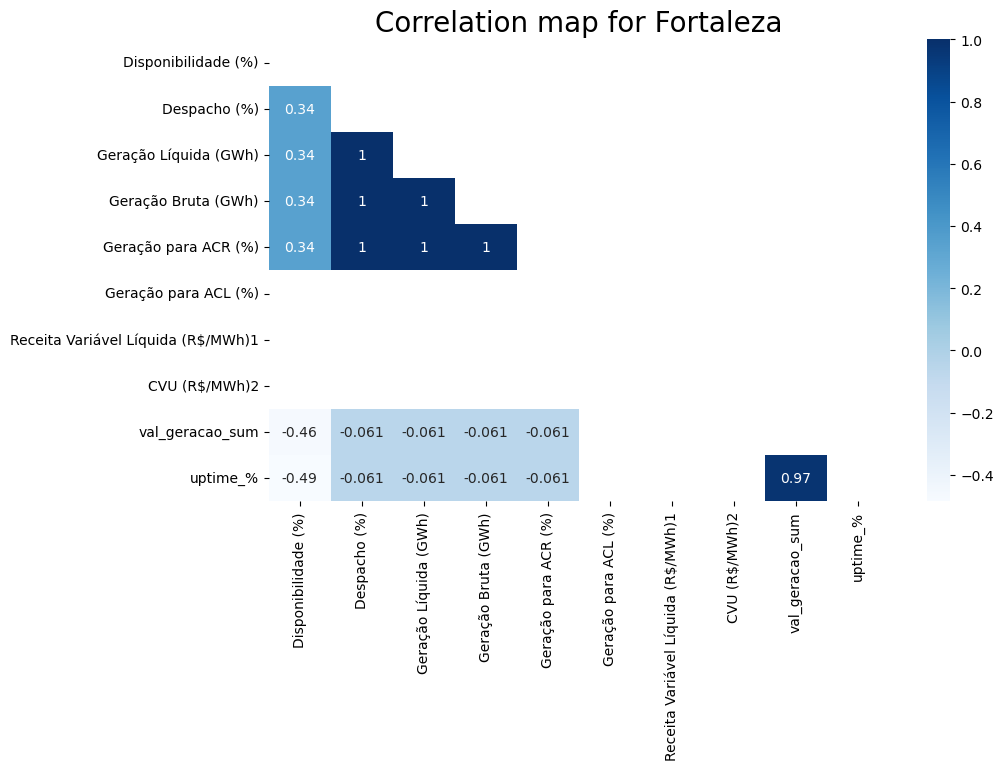

In [351]:
## CORRELATION FOR EACH POWERPLANT
powerplant_name = list_names[9]
corr = dt_together[dt_together['New_names']==powerplant_name].corr(method='spearman') #{‘pearson’, ‘kendall’, ‘spearman’} 
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(10, 6))
sns.heatmap(corr, mask=mask ,cmap="Blues", annot=True)
plt.title('Correlation map for ' + powerplant_name, fontsize = 20)
plt.show();

## Now plotting the correlation map using all the data at the same time.

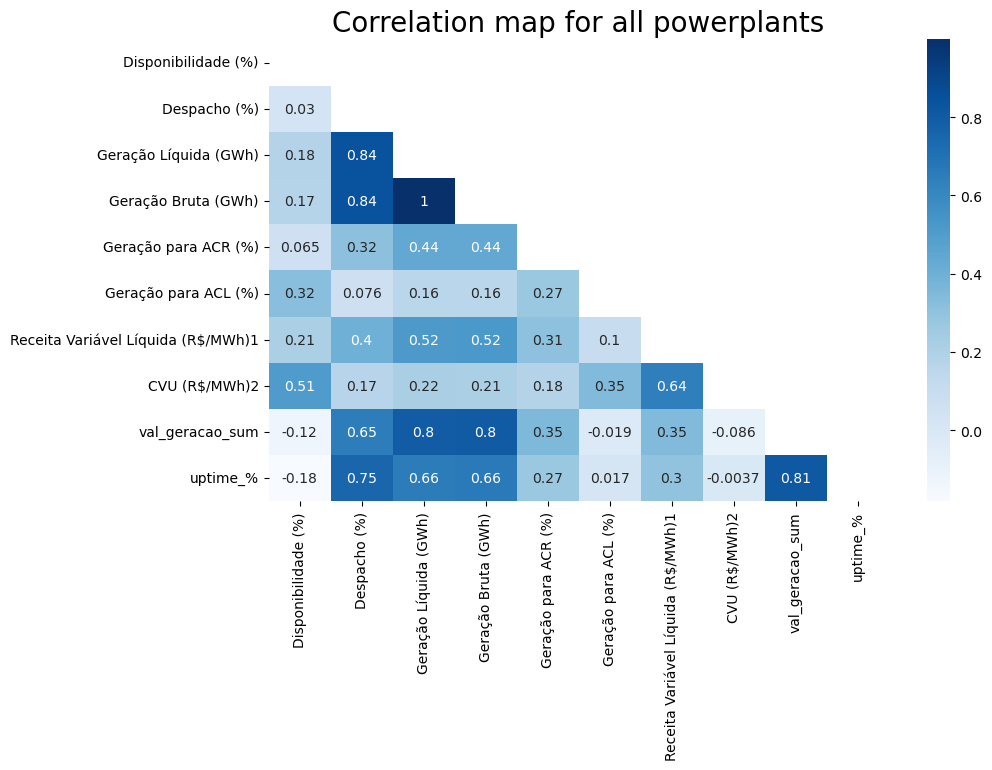

In [352]:
## CORRELATION FOR EACH POWERPLANT
corr = dt_together.corr(method='spearman') #{‘pearson’, ‘kendall’, ‘spearman’} 
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(10, 6))
sns.heatmap(corr, mask=mask ,cmap="Blues", annot=True)
plt.title('Correlation map for all powerplants', fontsize = 20)
plt.show();

Observe that for the power plants with larger historical data, the correlation between ONS and Eneva is close to 1, which is strong evidence that ONS data can be a powerful tool to predict Eneva's quarterly production performance. When grouping all data together, the correlation remains around 0.8, which again is a strong indicator of good predictive power.

Now the next step is to try to predict the Eneva value based on ONS data. For that task, I will attempt to use XGBoost and the ONS features 'val_geracao' and 'uptime' to predict 'Geração Bruta'

In [16]:
dt_together_all_test

,Quarter,total_val_geracao_ONS,total_active_hours_ONS,total_total_hours_ONS,total_geracao_bruta_ENEVA
12,19_1T,839.0,2626.0,17280.0,670.09
13,19_2T,765.0,2499.0,17472.0,680.80
14,19_3T,3780.0,12874.0,17664.0,3327.00
15,19_4T,4759.0,16575.0,18000.0,4287.82
16,20_1T,3053.0,10444.0,19152.0,2480.33
17,20_2T,879.0,1690.0,19656.0,366.33
18,20_3T,1255.0,3033.0,19872.0,1064.22
19,20_4T,4098.0,14364.0,19872.0,4068.20


In [18]:
# separeting the data in training test and validation sets
dt_together_all_train = dt_together_all[0:12].copy()
dt_together_all_test = dt_together_all[12:20].copy()
dt_together_all_vali = dt_together_all[20:28].copy()

In [19]:
# creating an input and output datasets.
X_train = dt_together_all_train[['total_val_geracao_ONS','quarter_uptime']].copy()
y_train = dt_together_all_train['total_geracao_bruta_ENEVA'].copy()

X_test = dt_together_all_test[['total_val_geracao_ONS','quarter_uptime']].copy()
y_test = dt_together_all_test['total_geracao_bruta_ENEVA'].copy()

X_validation = dt_together_all_vali[['total_val_geracao_ONS','quarter_uptime']].copy()
y_validation = dt_together_all_vali['total_geracao_bruta_ENEVA'].copy()

In [45]:
# Tunning the model with Gridsearch
hyperParameterTuning(X_train, y_train)

Fitting 5 folds for each of 2187 candidates, totalling 10935 fits


{'colsample_bytree': 0.2,
 'learning_rate': 0.2,
 'max_depth': 4,
 'min_child_weight': 1,
 'n_estimators': 500,
 'objective': 'reg:absoluteerror',
 'subsample': 0.5}

In [47]:
xgb_model = xgb.XGBRegressor(
        objective = 'reg:absoluteerror',
        min_child_weight= 1,
        colsample_bytree=0.2,
        learning_rate = 0.2,
        max_depth = 4,
        n_estimators = 500,
        subsample = 0.5)

%time xgb_model.fit(X_train, y_train, early_stopping_rounds=5, eval_set=[(X_test, y_test)], verbose=False)

y_pred_xgb = xgb_model.predict(X_test)

mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
print("MAE: ", mae_xgb)
print("MSE: ", mse_xgb)

CPU times: total: 141 ms
Wall time: 21.9 ms
MAE:  435.6165332031251
MSE:  280987.1743530079


In [48]:
y_validation_xgb = xgb_model.predict(X_validation)

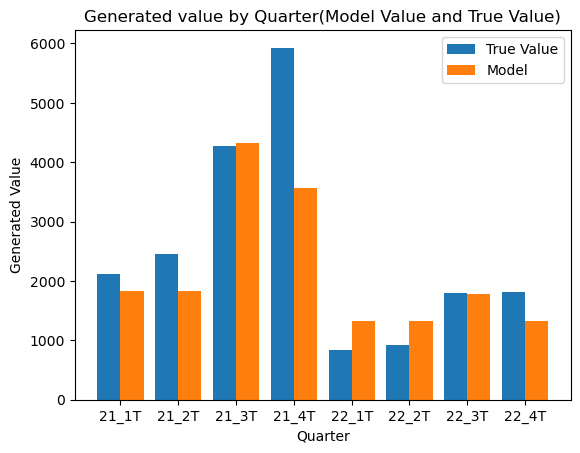

In [49]:
# ploting the value obtained with the model and comparing with the actual values
X = dt_together_all_vali["Quarter"].unique()
X_axis = np.arange(len(X)) 
plt.bar(X_axis - 0.2, y_validation, 0.4, label = 'True Value') 
plt.bar(X_axis + 0.2, y_validation_xgb, 0.4, label = 'Model') 
plt.xticks(X_axis, X) 
plt.xlabel("Quarter") 
plt.ylabel("Generated Value") 
plt.title("Generated value by Quarter(Model Value and True Value)") 
plt.legend() 
plt.show() 

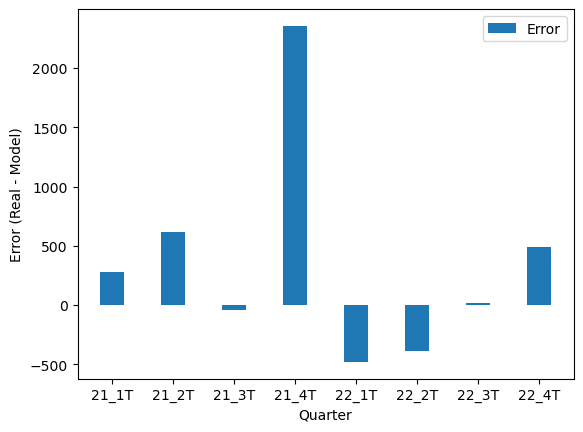

In [50]:
# showing the error for each quarter
X = dt_together_all_vali["Quarter"].unique()
X_axis = np.arange(len(X)) 
plt.bar(X_axis, y_validation-y_validation_xgb, 0.4, label = 'Error')  
plt.xticks(X_axis, X) 
plt.xlabel("Quarter") 
plt.ylabel("Error (Real - Model)") 
plt.legend() 
plt.show() 


## Final Observation

##From my observation, the ONS data has a high level of correlation with the Eneva production report value. It is important to note that ONS value is released monthly, and Eneva's is released quarterly; this particularity allows us to predict Eneva's value by aggregating the ONS value.

I tried to predict Eneva's quarterly value for 2021 and 2022 using ONS values (total production and uptime features). The results obtained were partially acceptable, since the majority of the quarters presented decent performance; however, the 2021 fourth quarter results were far from optimal.

Thinking about the actual implementation of a similar model, a better solution for this problem might be predicting the remaining ONS value to complete the quarter, then aggregating this prediction with the values that we know from ONS. For example, if we have the ONS value of January, we need to predict the value of February and March to complete the first quarter information. We can create a model to predict the ONS value and, after that, predict the Eneva value for the first quarter.

Summing up, the ONS data is powerful information to predict Eneva's quarterly report, but in order to optimize usability, it is necessary to tailor a strategy to increase the timeframe of the prediction.

Brainstorming to create the ONS model:

    Add the pluviometric data from Paraná and Pará, locations for two main hydroelectric power plants in Brazil (trying to add demand info).
    Reasoning: Some of the power plants are connected to the "sistema interligado Nacional," and whenever there is a drought, the demand for thermoelectric power plants increases.
    Coal and GLP market price fluctuation (trying to add cost info).
    Reasoning: Self-explanatory, main resources."